In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
#reading in data
file_path = r"C:\Users\user\Downloads\Train.csv"
file_path2 = r"C:\Users\user\Downloads\Test.csv"
data_train = pd.read_csv(file_path, encoding='latin1')
data_test = pd.read_csv(file_path2, encoding='latin1')

In [3]:
print(data_train.head())
print("----------------------------------------------------------------")
print(data_test.head())

  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

In [4]:
#concatinating test and train data
data_train['source']='train'
data_test['source']='test'
data = pd.concat([data_train, data_test],ignore_index=True)
print(data_train.shape, data_test.shape, data.shape)

(8523, 13) (5681, 12) (14204, 13)


In [5]:
#checking for null values
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [6]:
#describtive analysis
data.describe()

Item_Weight  Item_Visibility      Item_MRP  Outlet_Establishment_Year  \
count  11765.000000     14204.000000  14204.000000               14204.000000   
mean      12.792854         0.065953    141.004977                1997.830681   
std        4.652502         0.051459     62.086938                   8.371664   
min        4.555000         0.000000     31.290000                1985.000000   
25%        8.710000         0.027036     94.012000                1987.000000   
50%       12.600000         0.054021    142.247000                1999.000000   
75%       16.750000         0.094037    185.855600                2004.000000   
max       21.350000         0.328391    266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800

In [7]:
data.nunique()

Item_Identifier               1559
Item_Weight                    415
Item_Fat_Content                 5
Item_Visibility              13006
Item_Type                       16
Item_MRP                      8052
Outlet_Identifier               10
Outlet_Establishment_Year        9
Outlet_Size                      3
Outlet_Location_Type             3
Outlet_Type                      4
Item_Outlet_Sales             3493
source                           2
dtype: int64

In [8]:
#Filter categorical variables
categorical_columns = [x for x in data.dtypes.index if data.dtypes[x]=='object']
#Exclude ID cols and source:
categorical_columns = [x for x in categorical_columns if x not in ['Item_Identifier','Outlet_Identifier','source']]
#Print frequency of categories
for col in categorical_columns:
    print('\nFrequency of Categories for varible %s'%col)
    print (data[col].value_counts())


Frequency of Categories for varible Item_Fat_Content
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Frequency of Categories for varible Item_Type
Fruits and Vegetables    2013
Snack Foods              1989
Household                1548
Frozen Foods             1426
Dairy                    1136
Baking Goods             1086
Canned                   1084
Health and Hygiene        858
Meat                      736
Soft Drinks               726
Breads                    416
Hard Drinks               362
Others                    280
Starchy Foods             269
Breakfast                 186
Seafood                    89
Name: Item_Type, dtype: int64

Frequency of Categories for varible Outlet_Size
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64

Frequency of Categories for varible Outlet_Location_Type
Tier 3    5583
Tier 2    4641
Tier 1    3980
Name: Outlet_Location_Type, dtype: int64

F

In [9]:
#Determine the average weight per item:
item_avg_weight = data['Item_Weight'].mean()
item_avg_weight
# filling the iteam weight withe average weight
data['Item_Weight'] = data['Item_Weight'].fillna(item_avg_weight)

In [10]:
#Determine the common outlet size:
mode_outlet_size =  data['Outlet_Size'].mode()[0]
mode_outlet_size
data['Outlet_Size'] = data['Outlet_Size'].fillna(mode_outlet_size)

In [11]:
data.pivot_table(values='Item_Outlet_Sales',index='Outlet_Type')

Item_Outlet_Sales
Outlet_Type                         
Grocery Store             339.828500
Supermarket Type1        2316.181148
Supermarket Type2        1995.498739
Supermarket Type3        3694.038558

In [12]:
# Determine average visibility of a product
visibility_avg = data.groupby('Item_Identifier')['Item_Visibility'].mean()

# Impute 0 values with mean visibility of that product:
miss_bool = (data['Item_Visibility'] == 0)

print('Number of 0 values initially: %d' % sum(miss_bool))
data.loc[miss_bool, 'Item_Visibility'] = data.loc[miss_bool, 'Item_Identifier'].apply(lambda x: visibility_avg[x])
print('Number of 0 values after modification: %d' % sum(data['Item_Visibility'] == 0))


Number of 0 values initially: 879
Number of 0 values after modification: 0


In [13]:
#Determine another variable with means ratio
data['Item_Visibility_MeanRatio'] = data.apply(lambda x: x['Item_Visibility']/visibility_avg[x['Item_Identifier']], axis=1)
print(data['Item_Visibility_MeanRatio'].describe())

count    14204.000000
mean         1.061884
std          0.235907
min          0.844563
25%          0.925131
50%          0.999070
75%          1.042007
max          3.010094
Name: Item_Visibility_MeanRatio, dtype: float64


In [14]:
#Get the first two characters of ID:
data['Item_Type_Combined'] = data['Item_Identifier'].apply(lambda x: x[0:2])
#Rename them to more intuitive categories:
data['Item_Type_Combined'] = data['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
data['Item_Type_Combined'].value_counts()

Food              10201
Non-Consumable     2686
Drinks             1317
Name: Item_Type_Combined, dtype: int64

In [15]:
#Years:
data['Outlet_Years'] = 2024 - data['Outlet_Establishment_Year']
data['Outlet_Years'].describe()

count    14204.000000
mean        26.169319
std          8.371664
min         15.000000
25%         20.000000
50%         25.000000
75%         37.000000
max         39.000000
Name: Outlet_Years, dtype: float64

In [16]:
#Change categories of low fat:
print('Original Categories:')
print(data['Item_Fat_Content'].value_counts())

print('\nModified Categories:')
data['Item_Fat_Content'] = data['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})
print(data['Item_Fat_Content'].value_counts())

Original Categories:
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Modified Categories:
Low Fat    9185
Regular    5019
Name: Item_Fat_Content, dtype: int64


In [17]:
#Mark non-consumables as separate category in low_fat:
data.loc[data['Item_Type_Combined']=="Non-Consumable",'Item_Fat_Content'] = "Non-Edible"
data['Item_Fat_Content'].value_counts()

Low Fat       6499
Regular       5019
Non-Edible    2686
Name: Item_Fat_Content, dtype: int64

In [18]:
data

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0               FDA15         9.30          Low Fat         0.016047   
1               DRC01         5.92          Regular         0.019278   
2               FDN15        17.50          Low Fat         0.016760   
3               FDX07        19.20          Regular         0.017834   
4               NCD19         8.93       Non-Edible         0.009780   
...               ...          ...              ...              ...   
14199           FDB58        10.50          Regular         0.013496   
14200           FDD47         7.60          Regular         0.142991   
14201           NCO17        10.00       Non-Edible         0.073529   
14202           FDJ26        15.30          Regular         0.088380   
14203           FDU37         9.50          Regular         0.104720   

                   Item_Type  Item_MRP Outlet_Identifier  \
0                      Dairy  249.8092            OUT049   
1                Soft Drinks   48.2692            OUT018   
2                       Meat  141.6180            OUT049   
3      Fruits and Vegetables  182.0950            OUT010   
4                  Household   53.8614            OUT013   
...                      ...       ...               ...   
14199            Snack Foods  141.3154            OUT046   
14200          Starchy Foods  169.1448            OUT018   
14201     Health and Hygiene  118.7440            OUT045   
14202                 Canned  214.6218            OUT017   
14203                 Canned   79.7960            OUT045   

       Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                           1999      Medium               Tier 1   
1                           2009      Medium               Tier 3   
2                           1999      Medium               Tier 1   
3                           1998      Medium               Tier 3   
4                           1987        High               Tier 3   
...                          ...         ...                  ...   
14199                       1997       Small               Tier 1   
14200                       2009      Medium               Tier 3   
14201                       2002      Medium               Tier 2   
14202                       2007      Medium               Tier 2   
14203                       2002      Medium               Tier 2   

             Outlet_Type  Item_Outlet_Sales source  Item_Visibility_MeanRatio  \
0      Supermarket Type1          3735.1380  train                   0.931078   
1      Supermarket Type2           443.4228  train                   0.933420   
2      Supermarket Type1          2097.2700  train                   0.960069   
3          Grocery Store           732.3800  train                   1.000000   
4      Supermarket Type1           994.7052  train                   1.000000   
...                  ...                ...    ...                        ...   
14199  Supermarket Type1                NaN   test                   0.874729   
14200  Supermarket Type2                NaN   test                   0.878292   
14201  Supermarket Type1                NaN   test                   1.162245   
14202  Supermarket Type1                NaN   test                   1.000000   
14203  Supermarket Type1                NaN   test                   1.029678   

      Item_Type_Combined  Outlet_Years  
0                   Food            25  
1                 Drinks            15  
2                   Food            25  
3                   Food            26  
4         Non-Consumable            37  
...                  ...           ...  
14199               Food            27  
14200               Food            15  
14201     Non-Consumable            22  
14202               Food            17  
14203               Food            22  

[14204 rows x 16 columns]

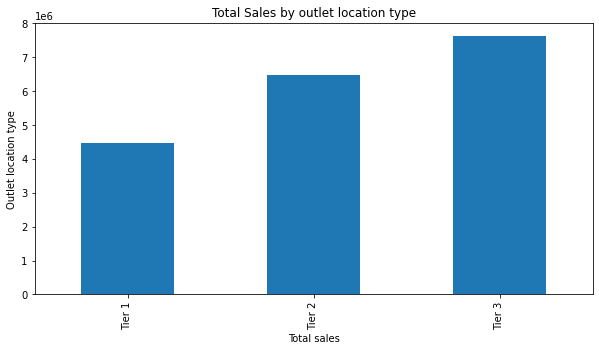

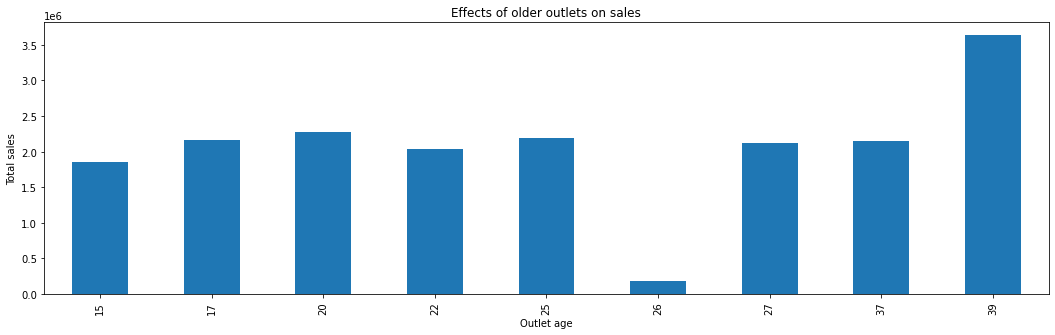

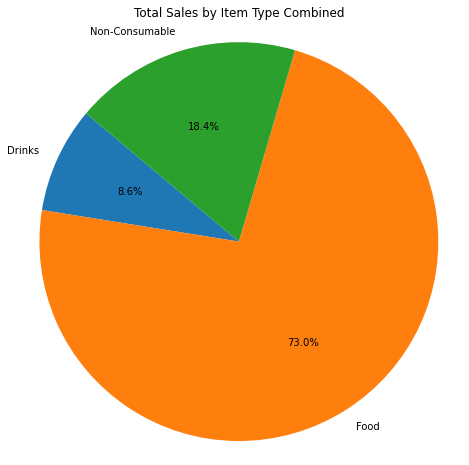

In [19]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#creating barchart for sales and outlet location
plt.figure(figsize=(10, 5))
train.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].sum().plot(kind='bar')
plt.title('Total Sales by outlet location type')
plt.xlabel('Total sales')
plt.ylabel('Outlet location type')

#create a bar chart for sales and outlet years
plt.figure(figsize=(18, 5))
train.groupby('Outlet_Years')['Item_Outlet_Sales'].sum().plot(kind='bar')
plt.title('Effects of older outlets on sales')
plt.ylabel('Total sales')
plt.xlabel('Outlet age')


sales_by_item_type = train.groupby('Item_Type_Combined')['Item_Outlet_Sales'].sum()

#Create a pie plot with increased size
plt.figure(figsize=(8, 8))
plt.pie(sales_by_item_type, labels=sales_by_item_type.index, autopct='%1.1f%%', startangle=140)
plt.title('Total Sales by Item Type Combined')
plt.axis('equal')  
plt.show();

In [20]:
#instanciating encoder
le = LabelEncoder()
#New variable for outlet
data['Outlet'] = le.fit_transform(data['Outlet_Identifier'])
var_mod = ['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Item_Type_Combined','Outlet_Type','Outlet']
le = LabelEncoder()
for i in var_mod:
    data[i] = le.fit_transform(data[i])

In [21]:
data

Item_Identifier  Item_Weight  Item_Fat_Content  Item_Visibility  \
0               FDA15         9.30                 0         0.016047   
1               DRC01         5.92                 2         0.019278   
2               FDN15        17.50                 0         0.016760   
3               FDX07        19.20                 2         0.017834   
4               NCD19         8.93                 1         0.009780   
...               ...          ...               ...              ...   
14199           FDB58        10.50                 2         0.013496   
14200           FDD47         7.60                 2         0.142991   
14201           NCO17        10.00                 1         0.073529   
14202           FDJ26        15.30                 2         0.088380   
14203           FDU37         9.50                 2         0.104720   

                   Item_Type  Item_MRP Outlet_Identifier  \
0                      Dairy  249.8092            OUT049   
1                Soft Drinks   48.2692            OUT018   
2                       Meat  141.6180            OUT049   
3      Fruits and Vegetables  182.0950            OUT010   
4                  Household   53.8614            OUT013   
...                      ...       ...               ...   
14199            Snack Foods  141.3154            OUT046   
14200          Starchy Foods  169.1448            OUT018   
14201     Health and Hygiene  118.7440            OUT045   
14202                 Canned  214.6218            OUT017   
14203                 Canned   79.7960            OUT045   

       Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  \
0                           1999            1                     0   
1                           2009            1                     2   
2                           1999            1                     0   
3                           1998            1                     2   
4                           1987            0                     2   
...                          ...          ...                   ...   
14199                       1997            2                     0   
14200                       2009            1                     2   
14201                       2002            1                     1   
14202                       2007            1                     1   
14203                       2002            1                     1   

       Outlet_Type  Item_Outlet_Sales source  Item_Visibility_MeanRatio  \
0                1          3735.1380  train                   0.931078   
1                2           443.4228  train                   0.933420   
2                1          2097.2700  train                   0.960069   
3                0           732.3800  train                   1.000000   
4                1           994.7052  train                   1.000000   
...            ...                ...    ...                        ...   
14199            1                NaN   test                   0.874729   
14200            2                NaN   test                   0.878292   
14201            1                NaN   test                   1.162245   
14202            1                NaN   test                   1.000000   
14203            1                NaN   test                   1.029678   

       Item_Type_Combined  Outlet_Years  Outlet  
0                       1            25       9  
1                       0            15       3  
2                       1            25       9  
3                       1            26       0  
4                       2            37       1  
...                   ...           ...     ...  
14199                   1            27       8  
14200                   1            15       3  
14201                   2            22       7  
14202                   1            17       2  
14203                   1            22       7  

[14204 rows x 17 columns]

In [22]:
#One Hot Coding:
data = pd.get_dummies(data, columns=['Item_Fat_Content','Outlet_Location_Type','Outlet_Size','Outlet_Type',
                              'Item_Type_Combined','Outlet'])

In [23]:
data[['Item_Fat_Content_0','Item_Fat_Content_1','Item_Fat_Content_2']].head(10)

Item_Fat_Content_0  Item_Fat_Content_1  Item_Fat_Content_2
0                   1                   0                   0
1                   0                   0                   1
2                   1                   0                   0
3                   0                   0                   1
4                   0                   1                   0
5                   0                   0                   1
6                   0                   0                   1
7                   1                   0                   0
8                   0                   0                   1
9                   0                   0                   1

In [24]:
#Drop the columns which have been converted to different types:
data.drop(['Item_Type','Outlet_Establishment_Year'],axis=1,inplace=True)

#Divide into test and train:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

#Drop unnecessary columns:
test.drop(['Item_Outlet_Sales','source'],axis=1,inplace=True)
train.drop(['source'],axis=1,inplace=True)

#Export files as modified versions:
train.to_csv("train_modified.csv",index=False)
test.to_csv("test_modified.csv",index=False)

In [25]:
data1 = pd.read_csv('train_modified.csv')

In [26]:
data1

Item_Identifier  Item_Weight  Item_Visibility  Item_MRP  \
0              FDA15        9.300         0.016047  249.8092   
1              DRC01        5.920         0.019278   48.2692   
2              FDN15       17.500         0.016760  141.6180   
3              FDX07       19.200         0.017834  182.0950   
4              NCD19        8.930         0.009780   53.8614   
...              ...          ...              ...       ...   
8518           FDF22        6.865         0.056783  214.5218   
8519           FDS36        8.380         0.046982  108.1570   
8520           NCJ29       10.600         0.035186   85.1224   
8521           FDN46        7.210         0.145221  103.1332   
8522           DRG01       14.800         0.044878   75.4670   

     Outlet_Identifier  Item_Outlet_Sales  Item_Visibility_MeanRatio  \
0               OUT049          3735.1380                   0.931078   
1               OUT018           443.4228                   0.933420   
2               OUT049          2097.2700                   0.960069   
3               OUT010           732.3800                   1.000000   
4               OUT013           994.7052                   1.000000   
...                ...                ...                        ...   
8518            OUT013          2778.3834                   0.874001   
8519            OUT045           549.2850                   1.001096   
8520            OUT035          1193.1136                   0.998881   
8521            OUT018          1845.5976                   1.041620   
8522            OUT046           765.6700                   1.027777   

      Outlet_Years  Item_Fat_Content_0  Item_Fat_Content_1  ...  Outlet_0  \
0               25                   1                   0  ...         0   
1               15                   0                   0  ...         0   
2               25                   1                   0  ...         0   
3               26                   0                   0  ...         1   
4               37                   0                   1  ...         0   
...            ...                 ...                 ...  ...       ...   
8518            37                   1                   0  ...         0   
8519            22                   0                   0  ...         0   
8520            20                   0                   1  ...         0   
8521            15                   0                   0  ...         0   
8522            27                   1                   0  ...         0   

      Outlet_1  Outlet_2  Outlet_3  Outlet_4  Outlet_5  Outlet_6  Outlet_7  \
0            0         0         0         0         0         0         0   
1            0         0         1         0         0         0         0   
2            0         0         0         0         0         0         0   
3            0         0         0         0         0         0         0   
4            1         0         0         0         0         0         0   
...        ...       ...       ...       ...       ...       ...       ...   
8518         1         0         0         0         0         0         0   
8519         0         0         0         0         0         0         1   
8520         0         0         0         0         0         1         0   
8521         0         0         1         0         0         0         0   
8522         0         0         0         0         0         0         0   

      Outlet_8  Outlet_9  
0            0         1  
1            0         0  
2            0         1  
3            0         0  
4            0         0  
...        ...       ...  
8518         0         0  
8519         0         0  
8520         0         0  
8521         0         0  
8522         1         0  

[8523 rows x 34 columns]

In [27]:
# defining features and target 
X = data1.drop(columns=['Item_Identifier', 'Outlet_Identifier', 'Item_Outlet_Sales'])
y = data1['Item_Outlet_Sales']

In [28]:
print(X.shape)
print(y.shape)

(8523, 31)
(8523,)


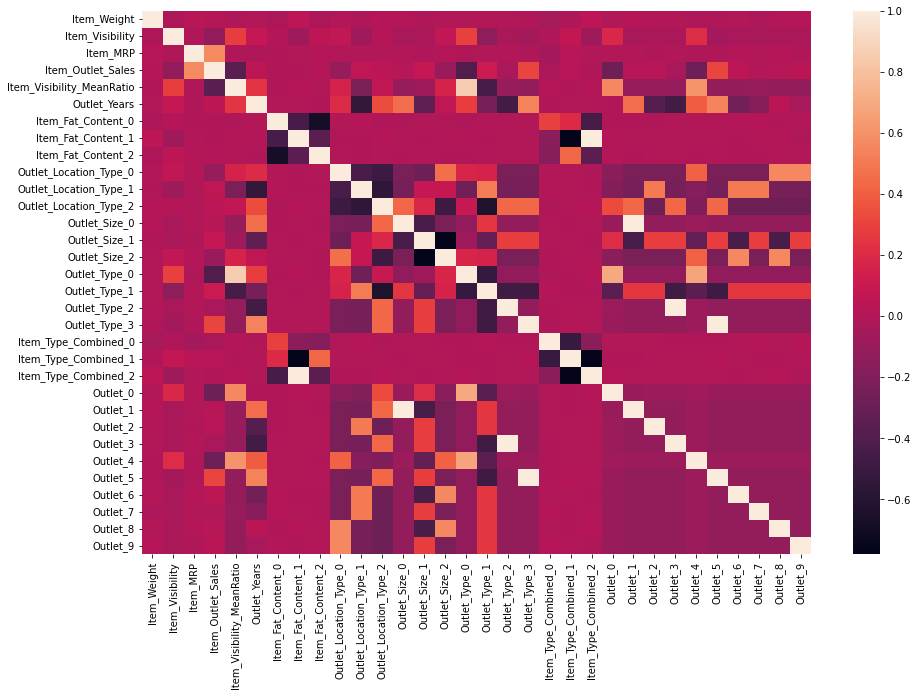

In [29]:
# correlation heat map
plt.figure(figsize=(15, 10))
sns.heatmap(data1.corr());

In [30]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building 

In [31]:
#Baseline model
baseline_predict = ([y_train.mean()]*len(y_train))
mae = mean_absolute_error(y_train,baseline_predict)
print("Baseline model Mean Absolute Error:", mae)

Baseline model Mean Absolute Error: 1357.4626666789156


In [32]:
#instanciating Linear regression
model = LinearRegression()
#Training model
model.fit(X_train, y_train)
#Prediction
pred = model.predict(X_test)
#Calxulating Mean absolute error
mae1 = mean_absolute_error(y_test,pred)
print("Linear regression model Mean Absolute Error:", mae1)

Linear regression model Mean Absolute Error: 790.9969019965614


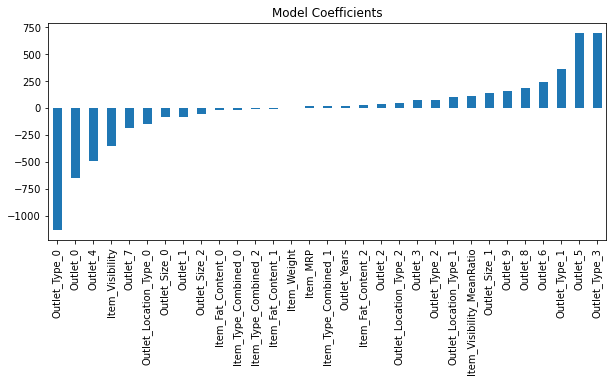

In [33]:
#obtaining coefficients a nd intercepts
slope = model.coef_
intercept = model.intercept_

# Generate points along the regression line
x_values = np.linspace(np.min(X), np.max(X), 100)
y_values = slope * x_values + intercept
coef = pd.Series(slope, X_test.columns).sort_values()
plt.figure(figsize=(10, 4))
coef.plot(kind='bar', title='Model Coefficients');

In [34]:
def reg_line(pred, text):
    for i in X_test.columns:
        plt.figure(figsize=(8, 6))
        plt.scatter(X_test[i], y_test, label='True values')
        x = np.array(X_test[i])
        y = np.array(pred)
        b1, b0 = np.polyfit(x, y, 1)
        plt.plot(x, b1*x + b0, color='red', label=f'Linear Equation: y = {b1:.2f}x + {b0:.2f}')
        plt.xlabel(i)
        plt.ylabel('Predicted values')
        plt.title(f'Predicted vs True values for {i}')
        plt.legend()
        plt.show()

RMSE  for linear regression:  1145.1197643859607


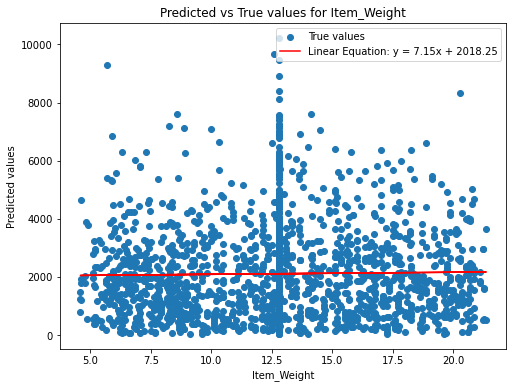

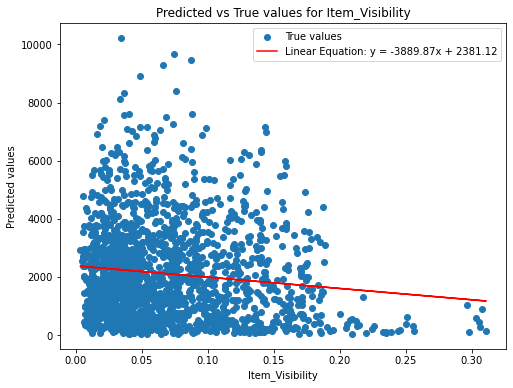

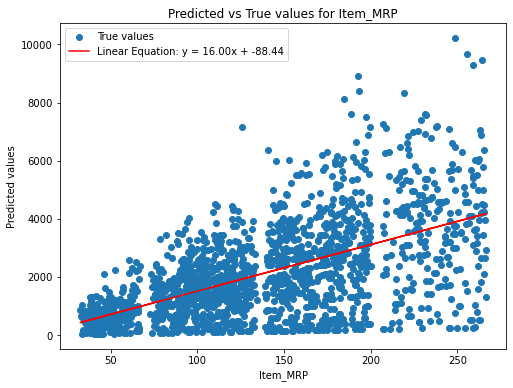

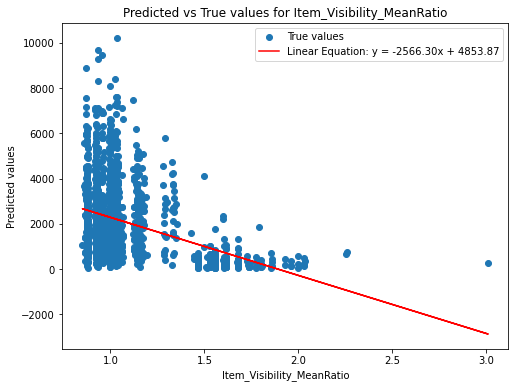

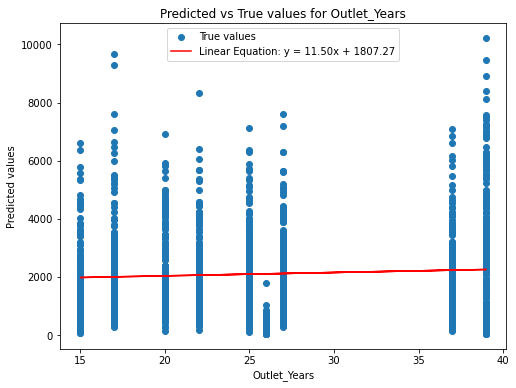

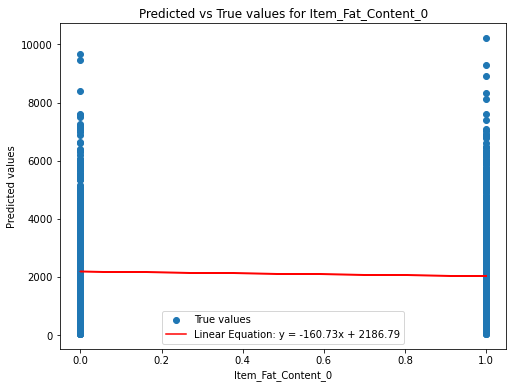

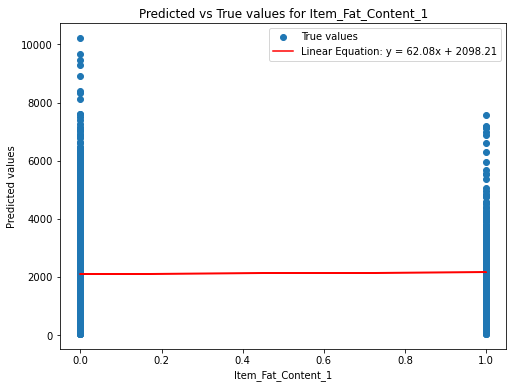

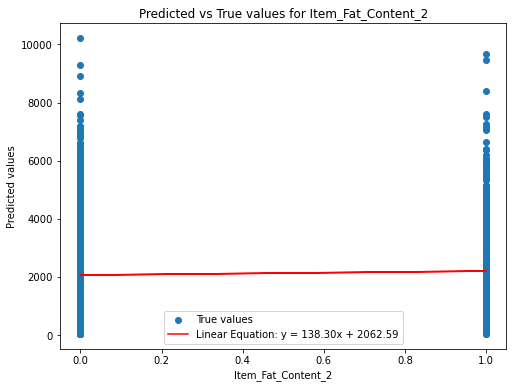

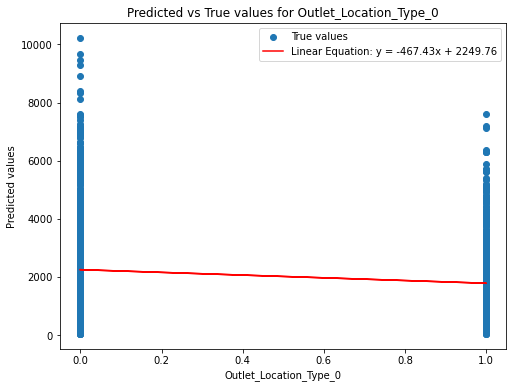

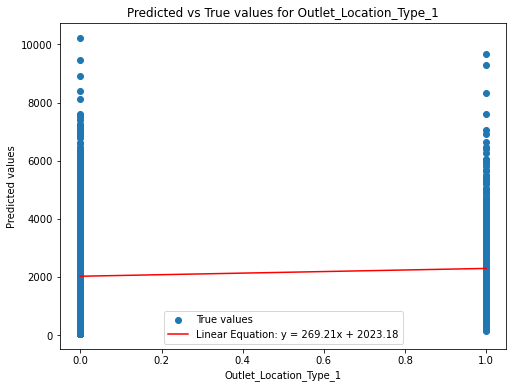

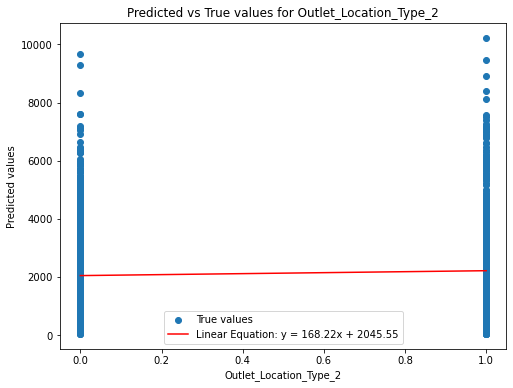

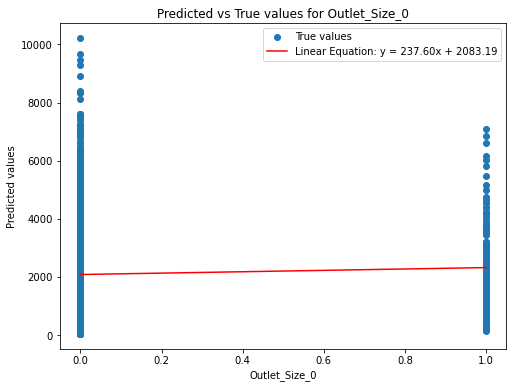

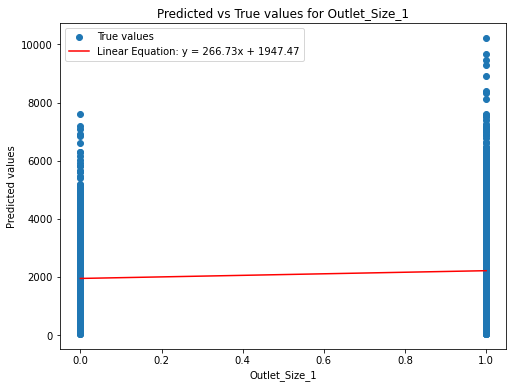

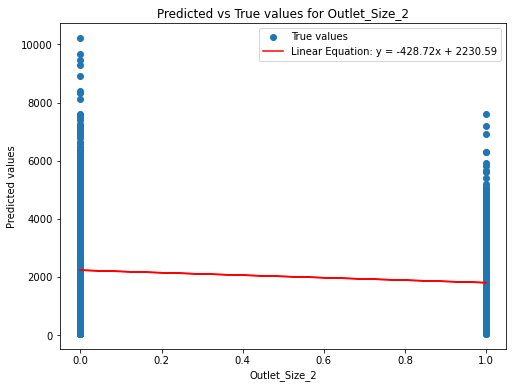

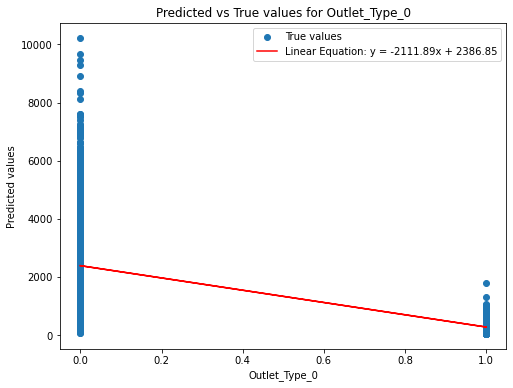

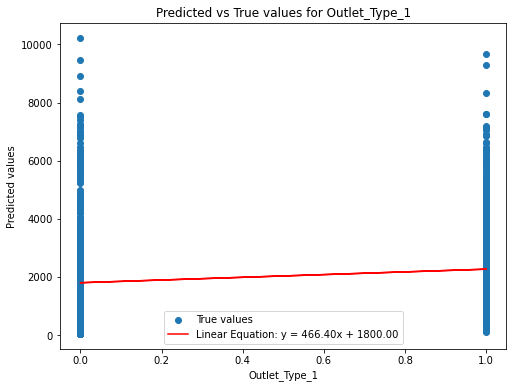

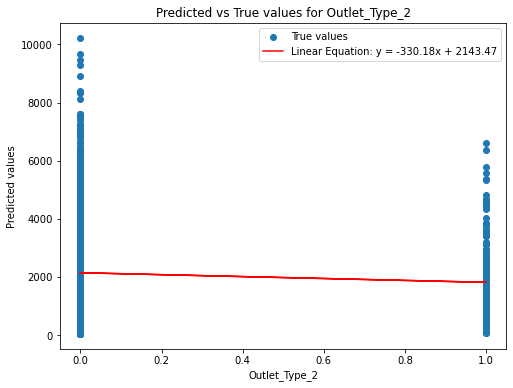

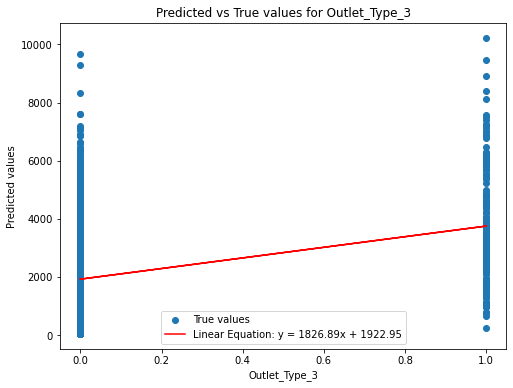

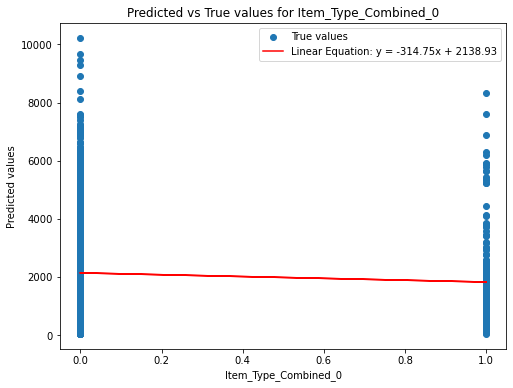

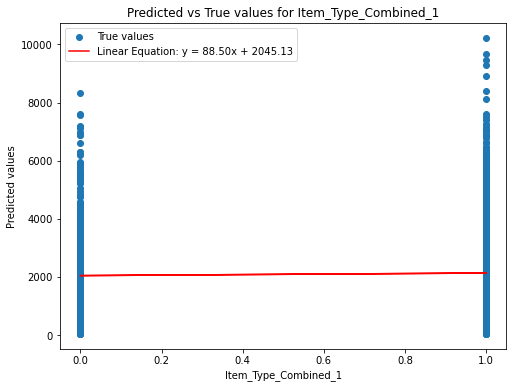

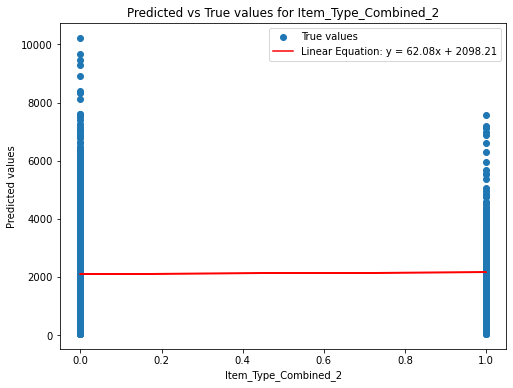

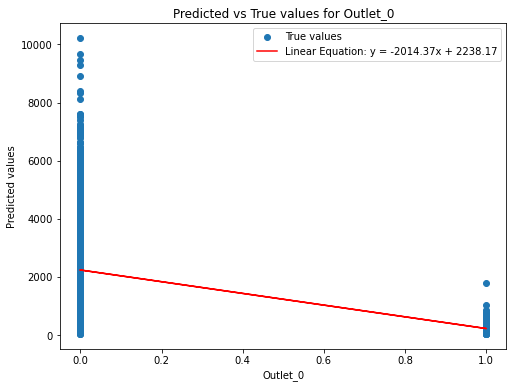

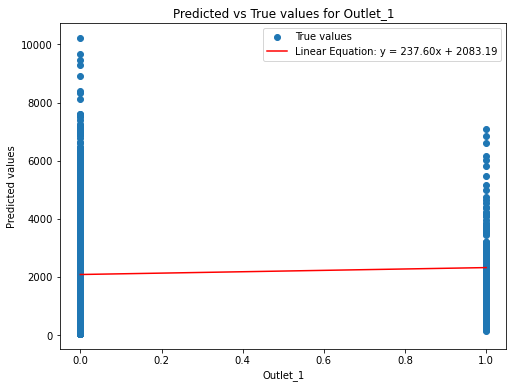

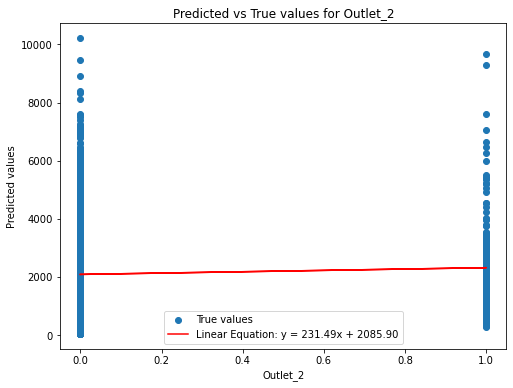

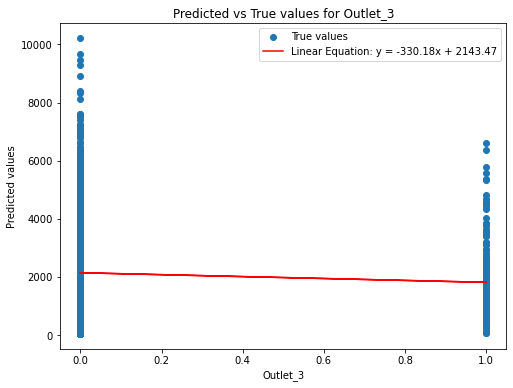

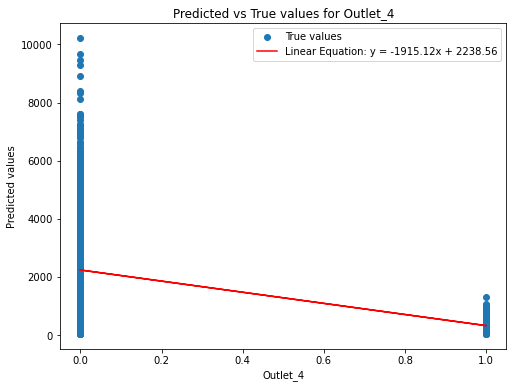

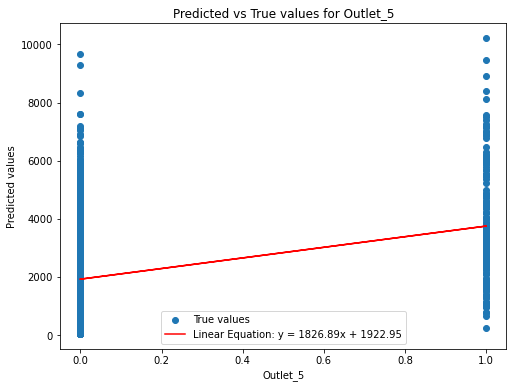

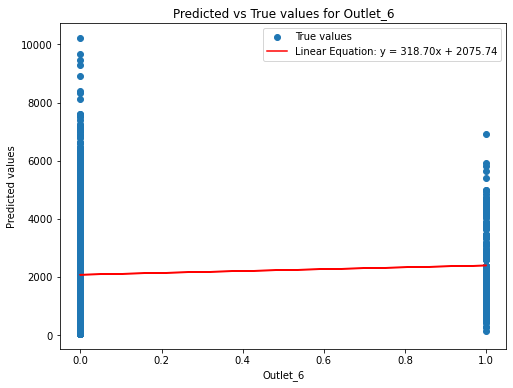

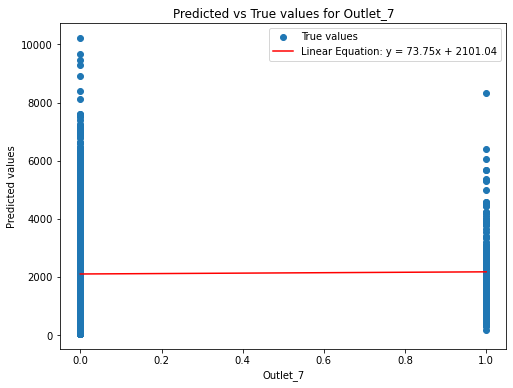

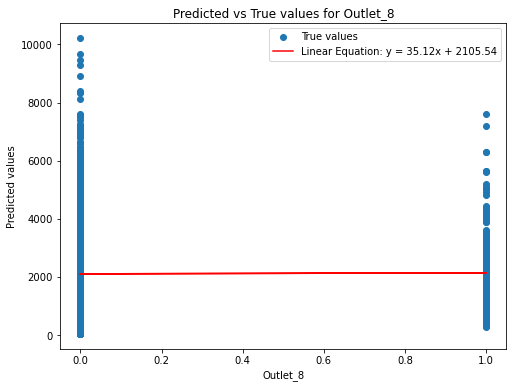

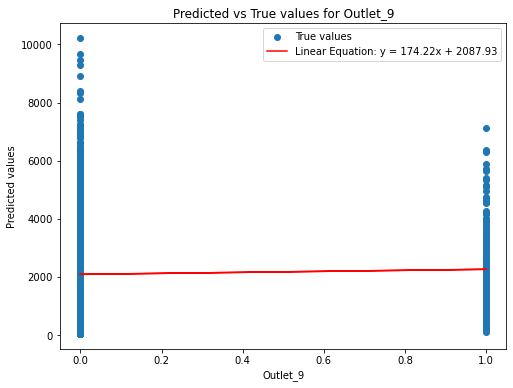

In [35]:
cv_scores = cross_val_score(model, X_train, y_train, cv=20, scoring='neg_mean_squared_error')
# Convert negative MSE scores to positive and take square root to get RMSE
cv_rmse = np.sqrt(-cv_scores.mean())
print('RMSE  for linear regression: ', cv_rmse)
reg_line(pred=pred, text=X_test)

In [36]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10),
                                                            cv=5, scoring='neg_mean_absolute_error')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("Mean Absolute Error")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.show()


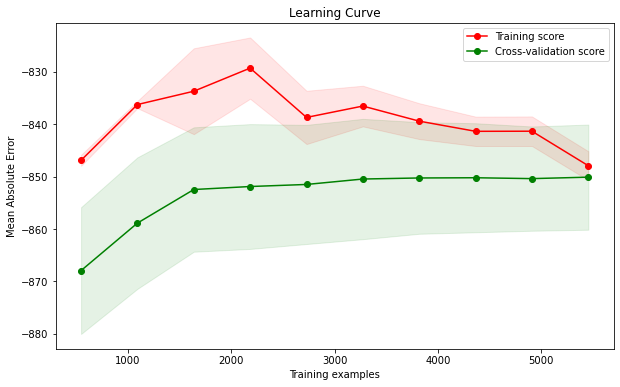

In [37]:
plot_learning_curve(model, X_train, y_train)

Ridge regression model Mean Absolute Error: 790.9969019965614


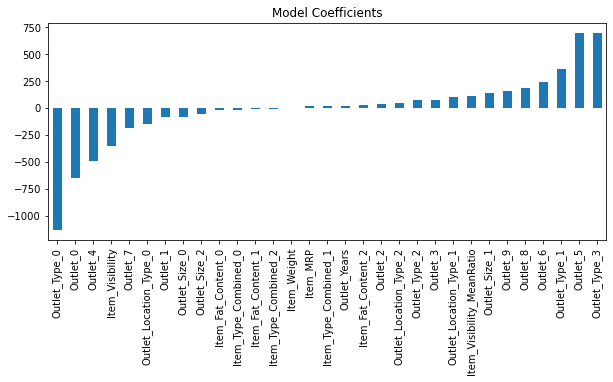

In [38]:
# instaciating Ridge regression
model2 = Ridge(alpha=0.05)
#Training model
model2.fit(X_train, y_train)
#predicting
pred2 = model.predict(X_test)
#calculating mean absolute error
mae2 = mean_absolute_error(y_test,pred2)
print("Ridge regression model Mean Absolute Error:", mae2)
coef2 = pd.Series(model2.coef_, X_test.columns).sort_values()
plt.figure(figsize=(10, 4))
coef2.plot(kind='bar', title='Model Coefficients');

RMSE  for Ridge regression:  1145.1189417160808


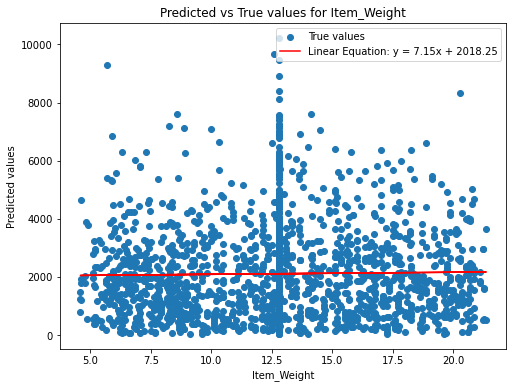

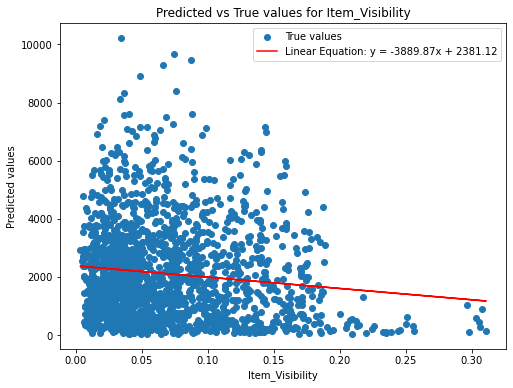

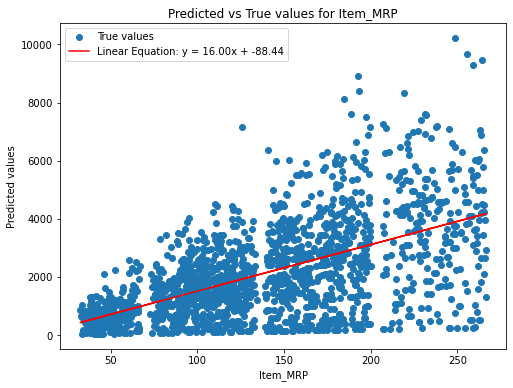

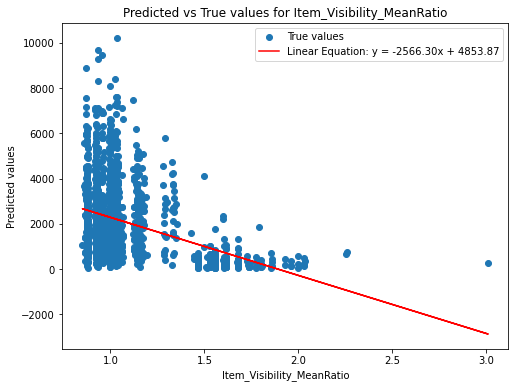

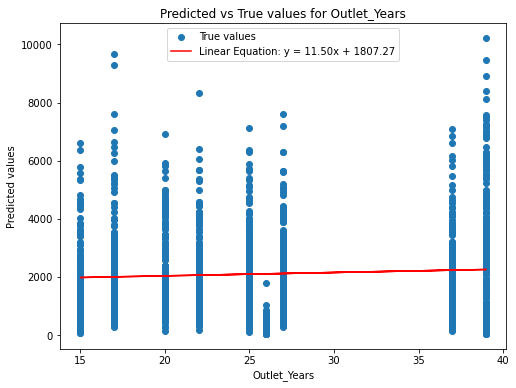

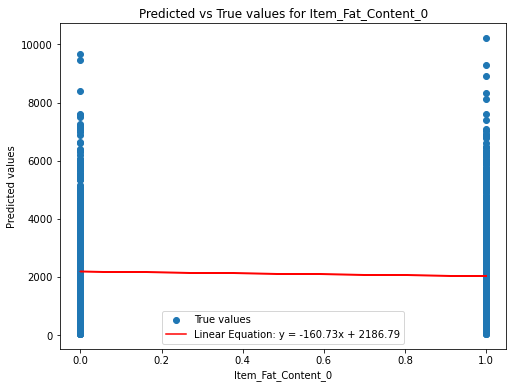

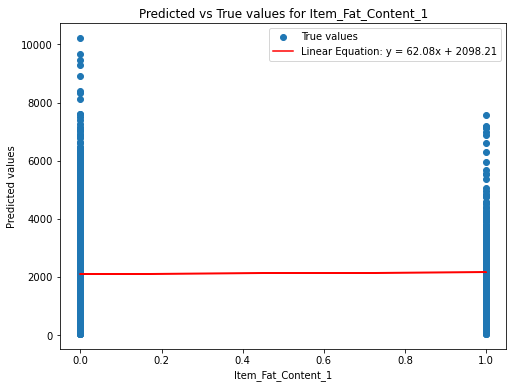

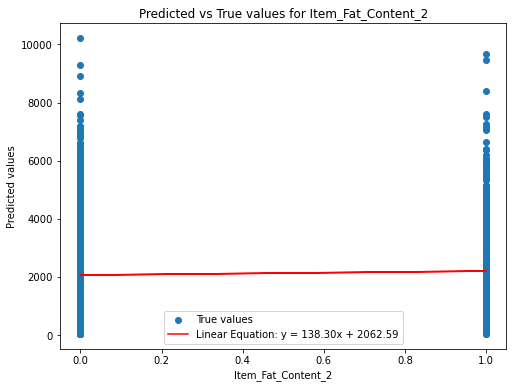

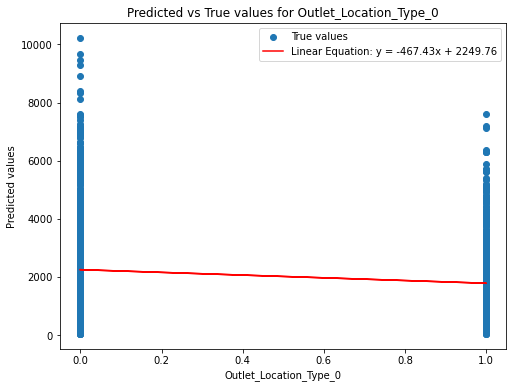

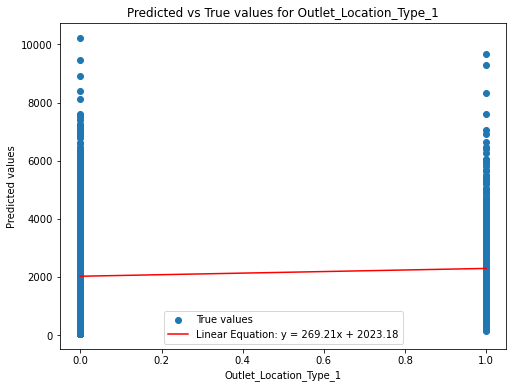

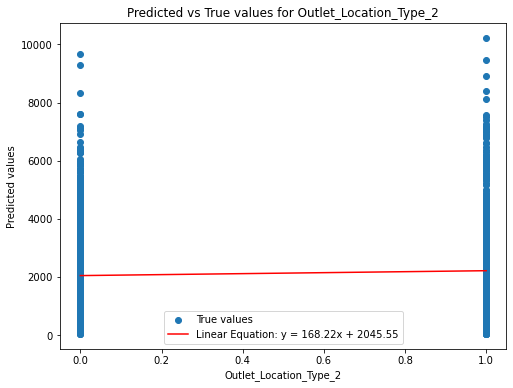

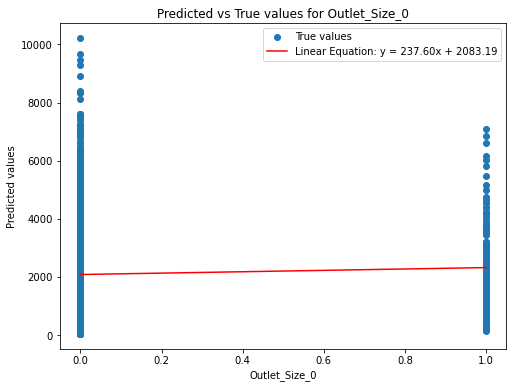

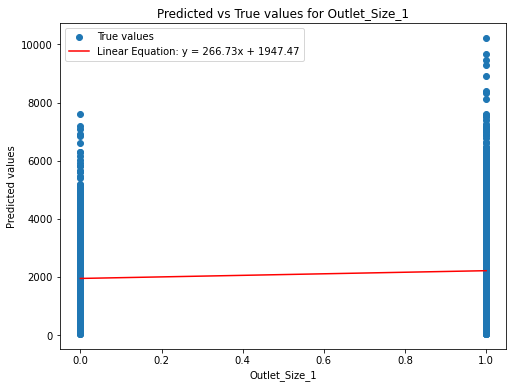

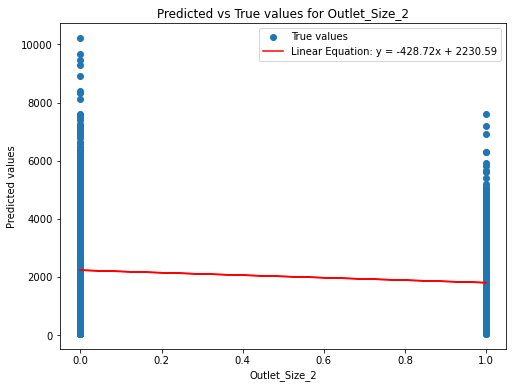

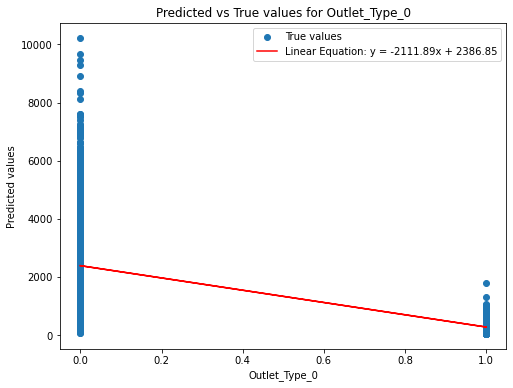

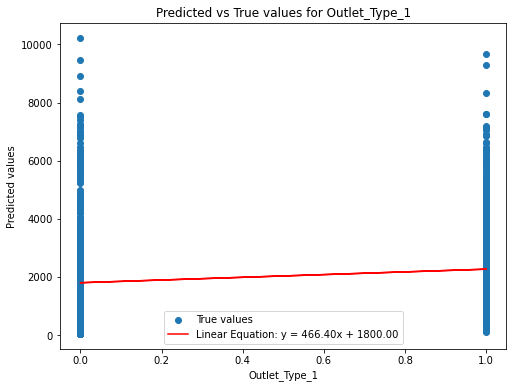

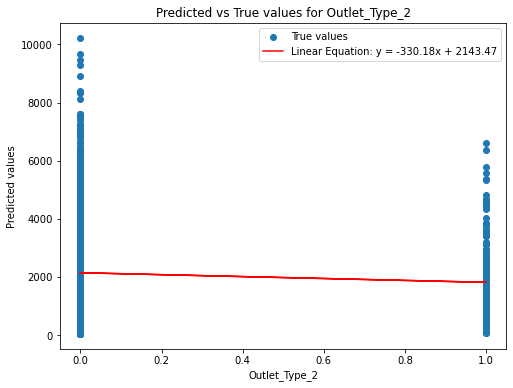

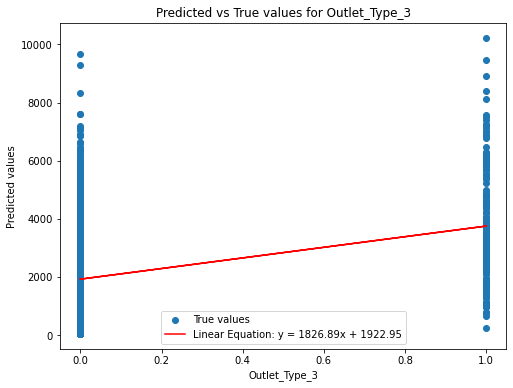

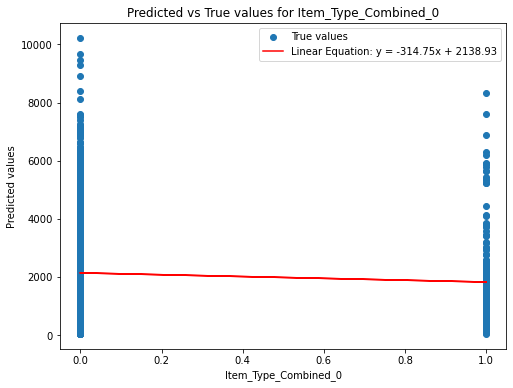

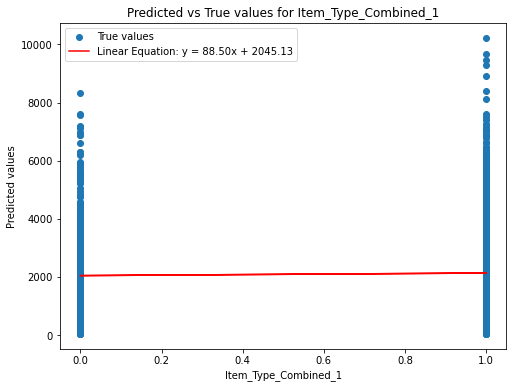

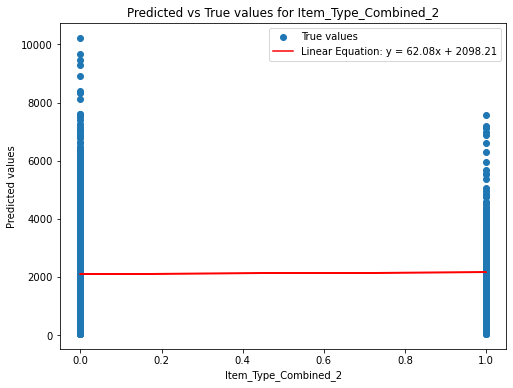

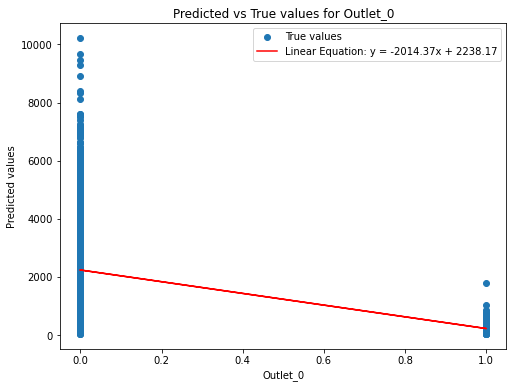

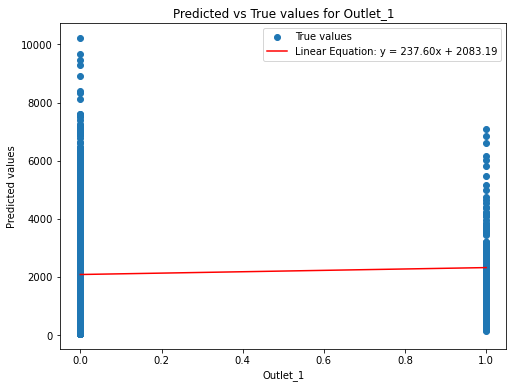

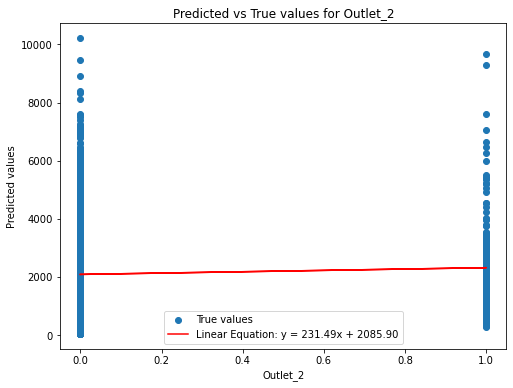

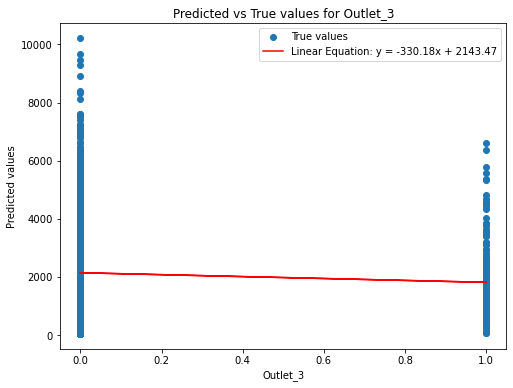

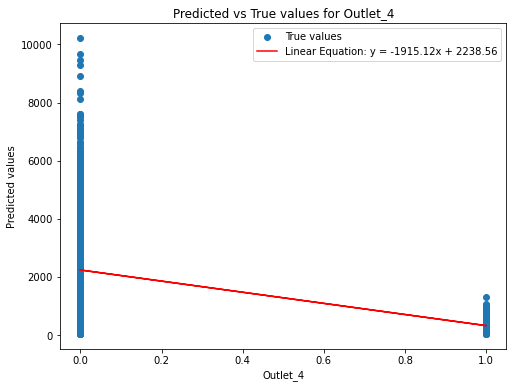

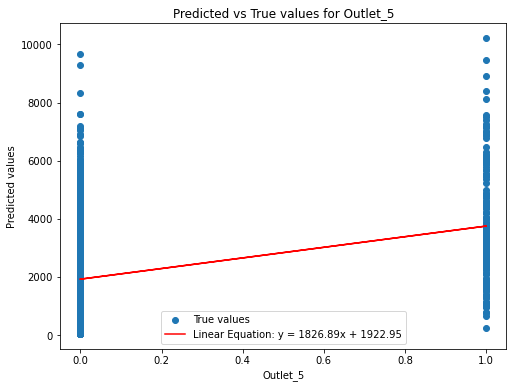

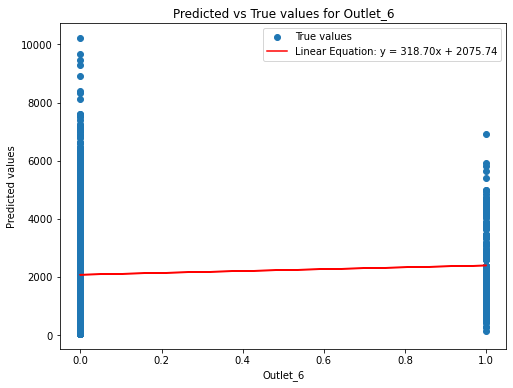

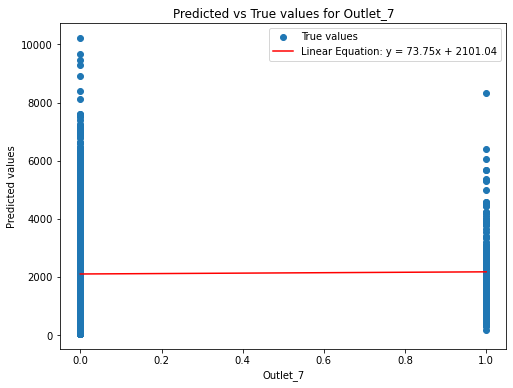

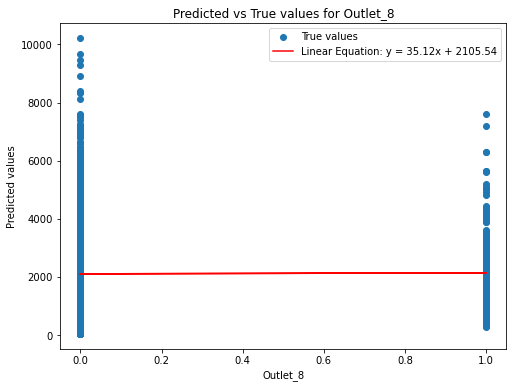

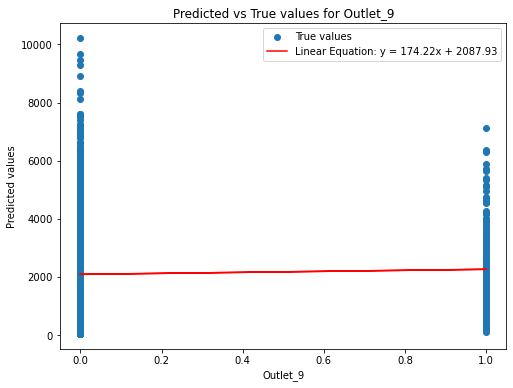

In [39]:
cv_scores2 = cross_val_score(model2, X_train, y_train, cv=20, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive and take square root to get RMSE
cv_rmse2 = np.sqrt(-cv_scores2.mean())
print('RMSE  for Ridge regression: ', cv_rmse2)
reg_line(pred=pred2, text=X_test)

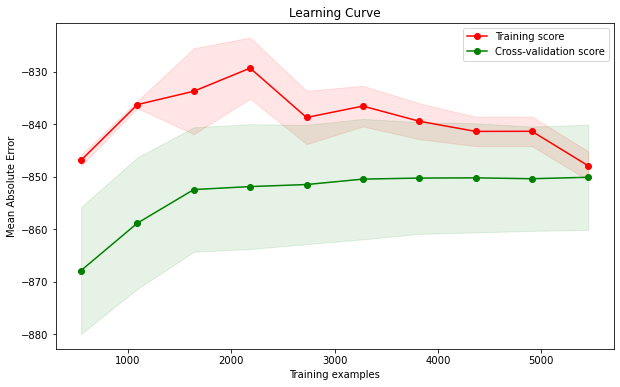

In [40]:
plot_learning_curve(model2, X_train, y_train)

DEcesion Tree model Mean Absolute Error: 726.5486645029306


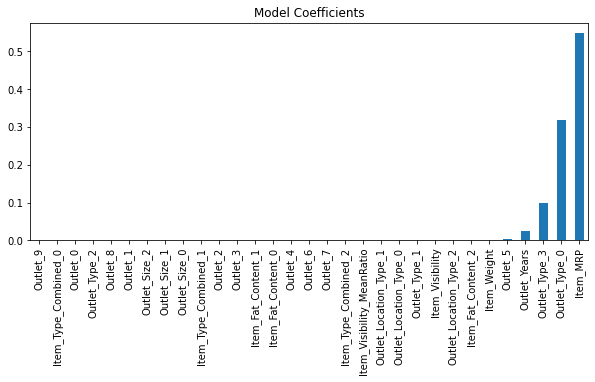

In [41]:
#instanciating decesion tree regression
model3 = DecisionTreeRegressor(max_depth=15, min_samples_leaf=100)
# training model
model3.fit(X_train, y_train)
#predicting
pred3 = model3.predict(X_test)
mae3 = mean_absolute_error(y_test,pred3)
print("DEcesion Tree model Mean Absolute Error:", mae3)
coef3 = pd.Series(model3.feature_importances_, X_test.columns).sort_values()
plt.figure(figsize=(10, 4))
coef3.plot(kind='bar', title='Model Coefficients');

RMSE  for decision tree regression:  1115.267653705788


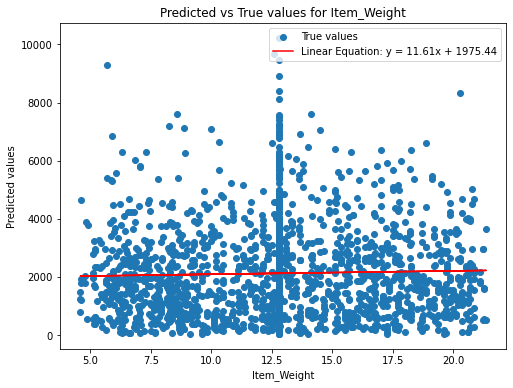

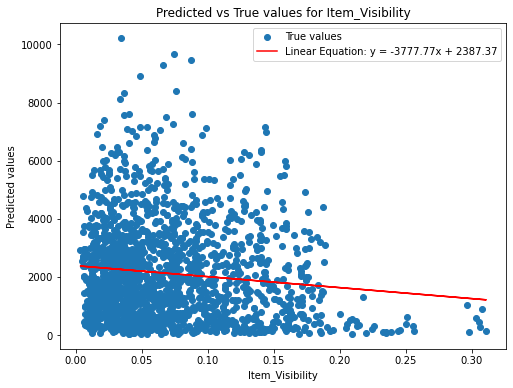

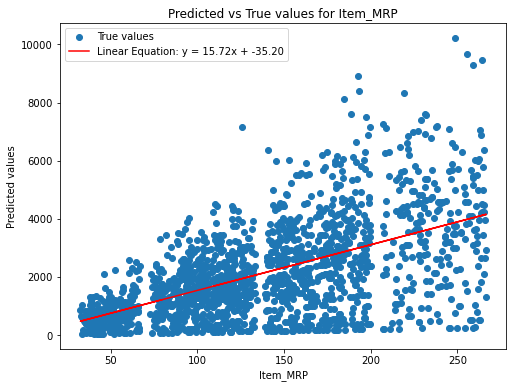

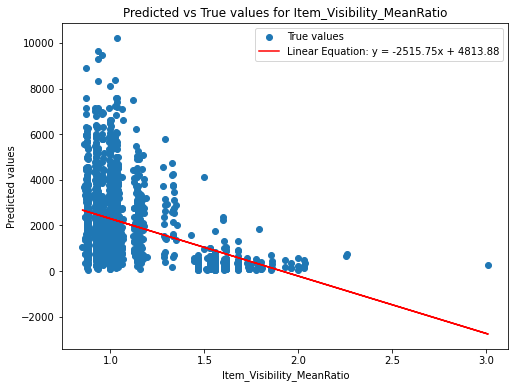

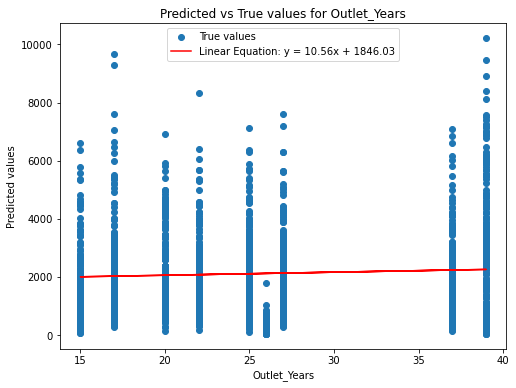

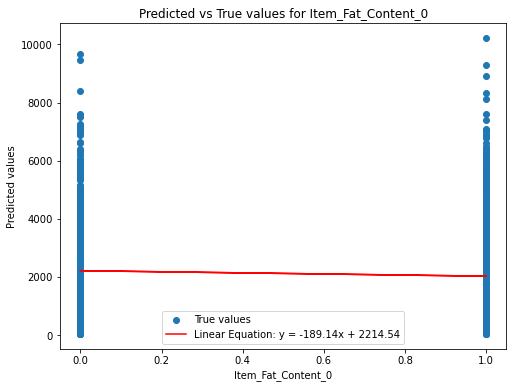

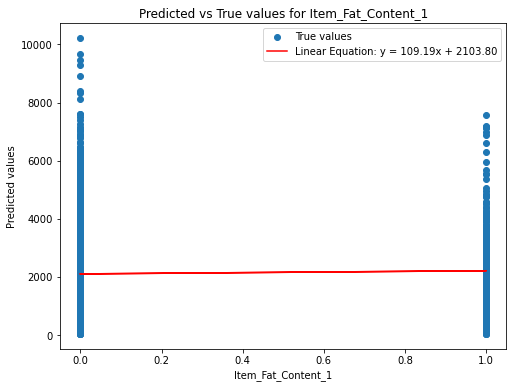

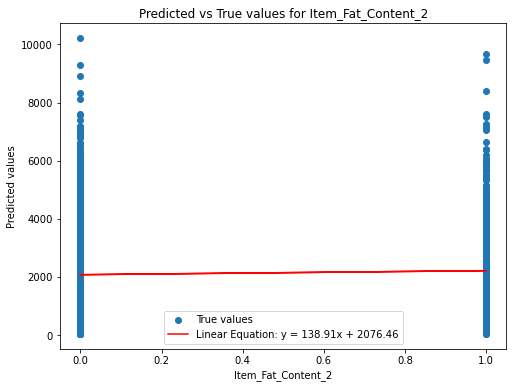

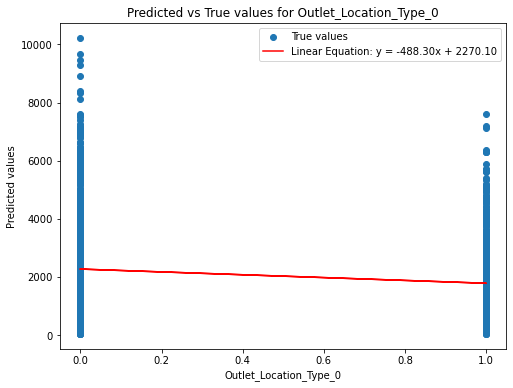

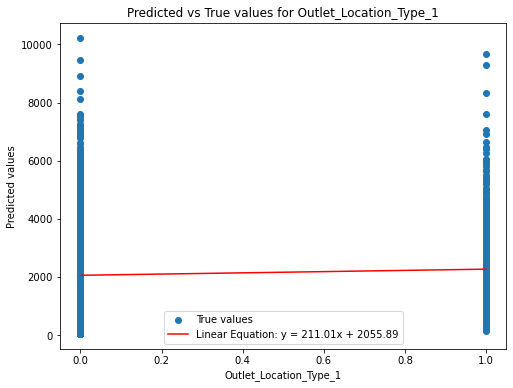

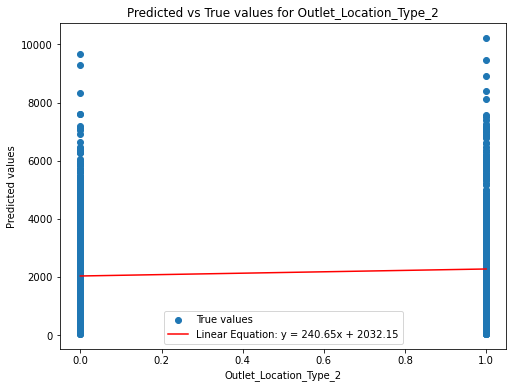

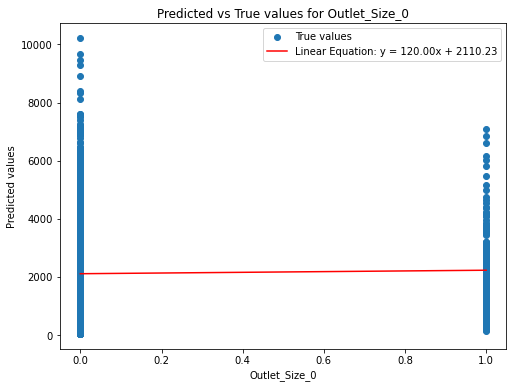

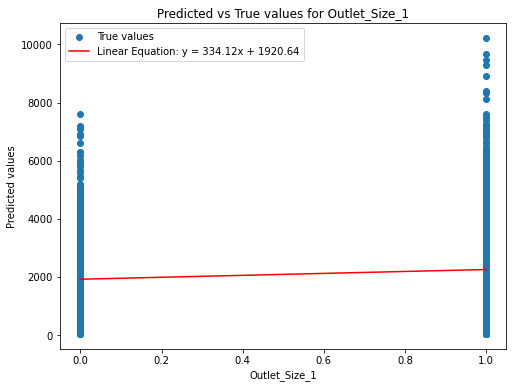

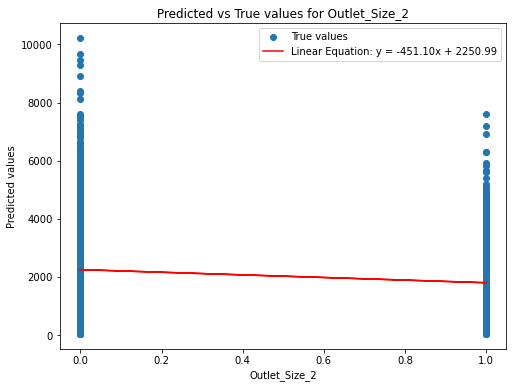

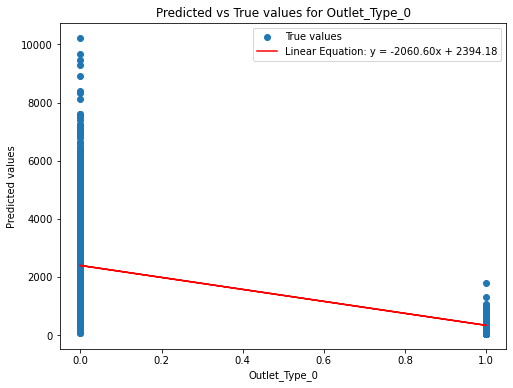

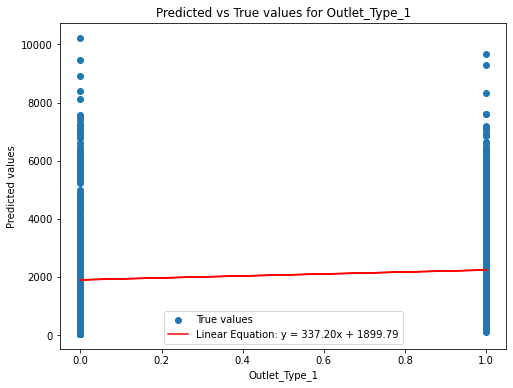

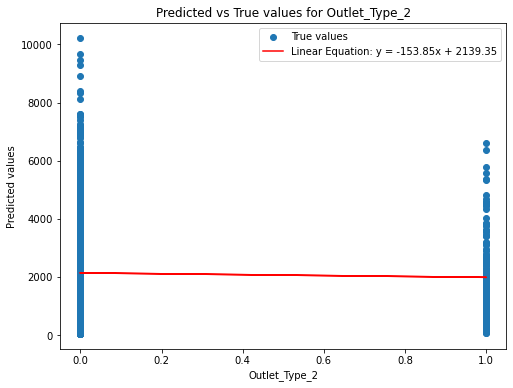

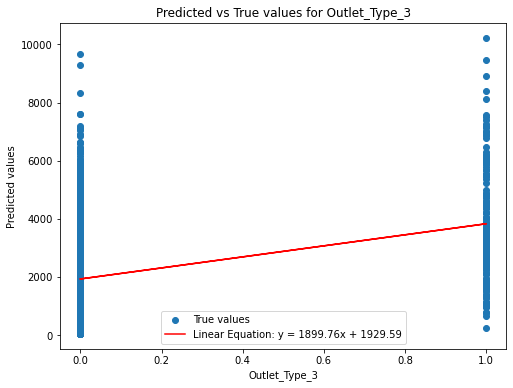

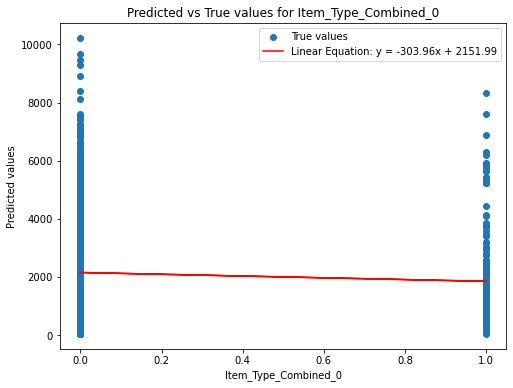

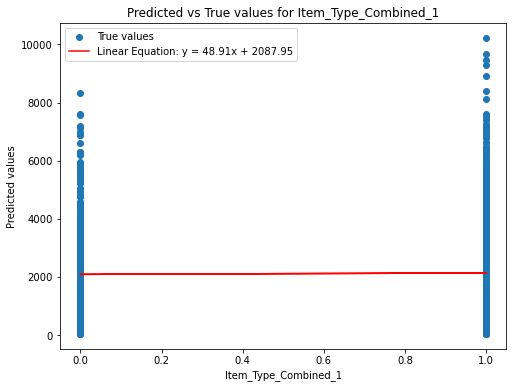

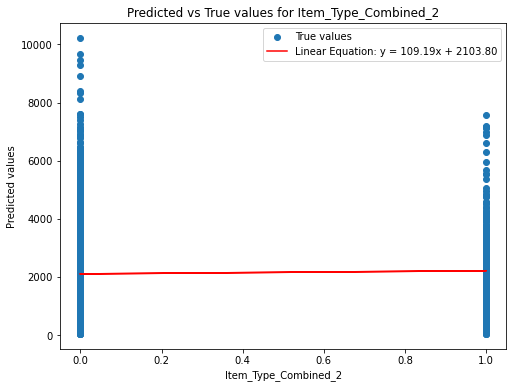

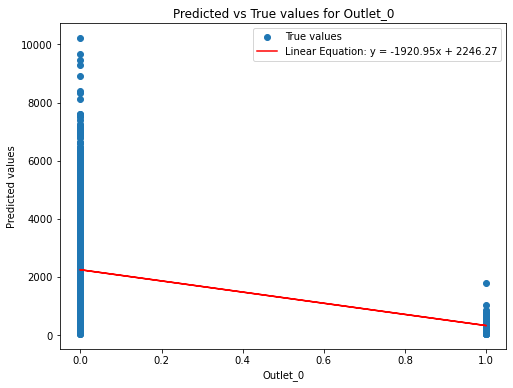

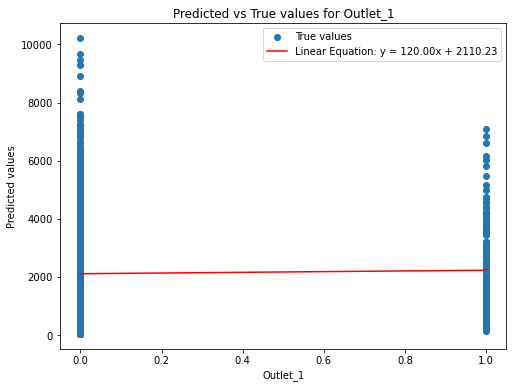

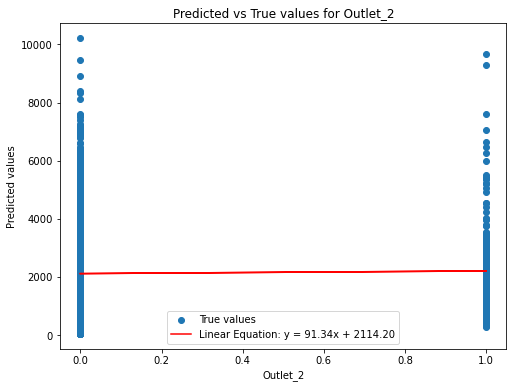

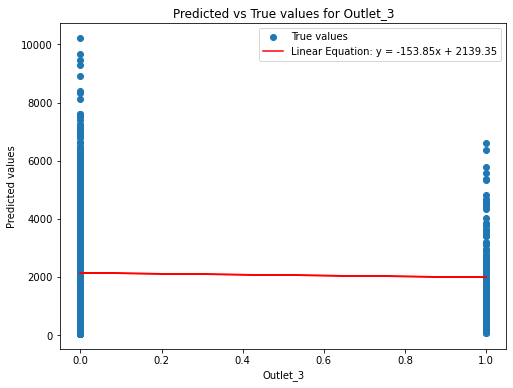

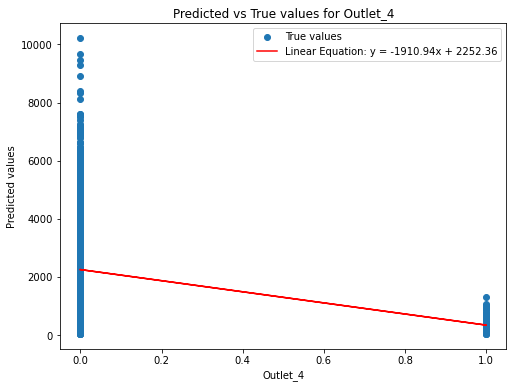

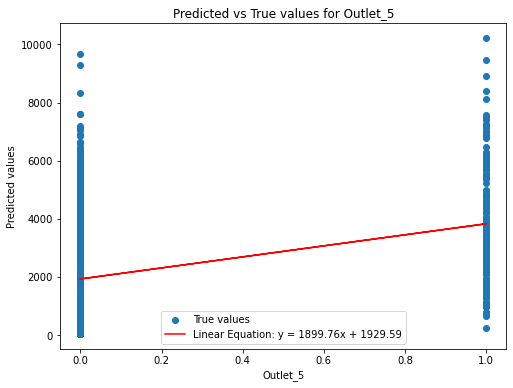

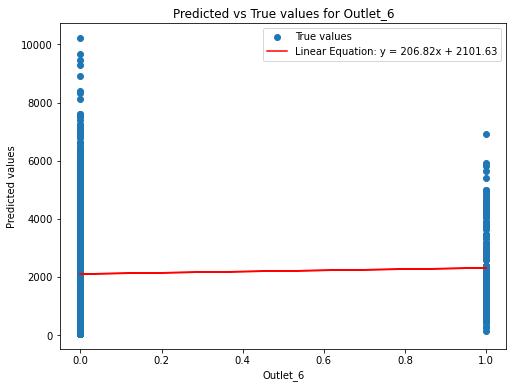

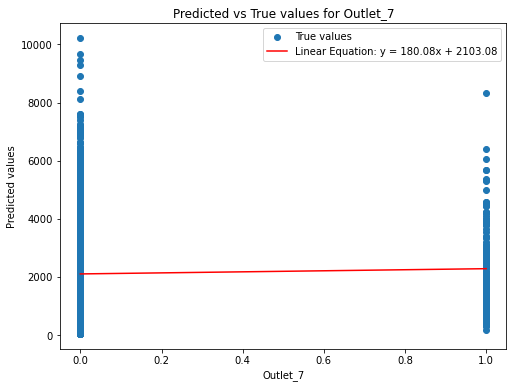

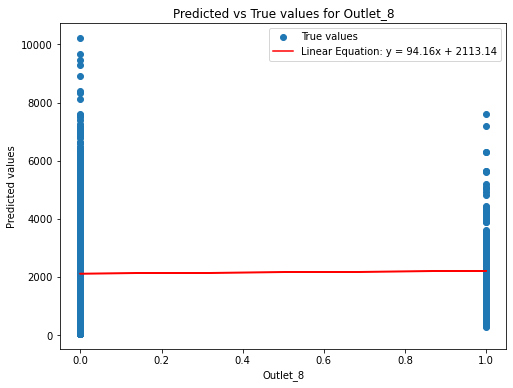

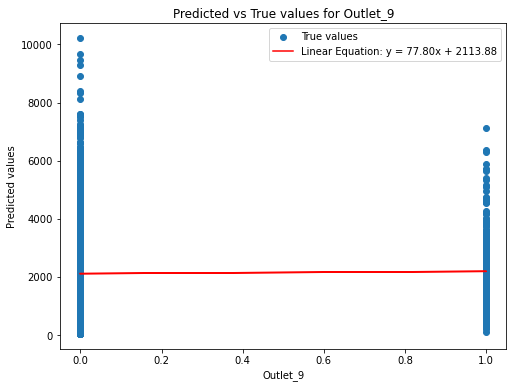

In [42]:
cv_scores3 = cross_val_score(model3, X_train, y_train, cv=20, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive and take square root to get RMSE
cv_rmse3 = np.sqrt(-cv_scores3.mean())
print('RMSE  for decision tree regression: ', cv_rmse3)
reg_line(pred=pred3, text=X_test)

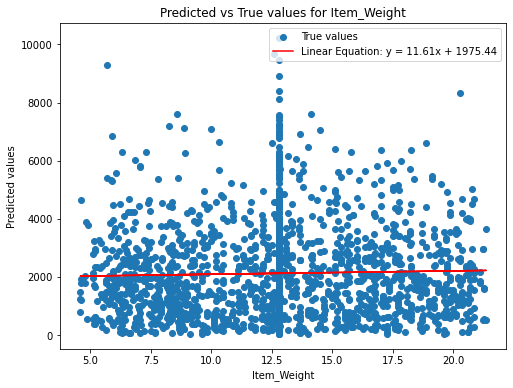

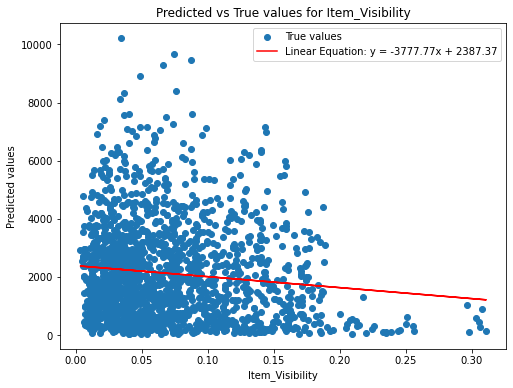

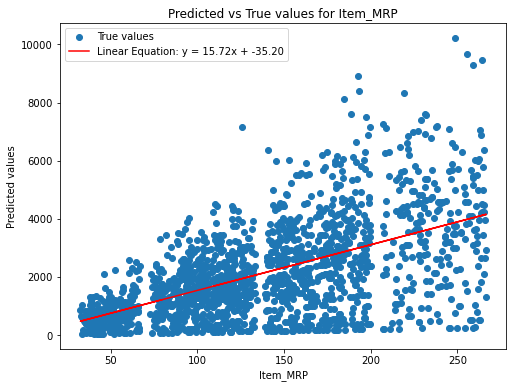

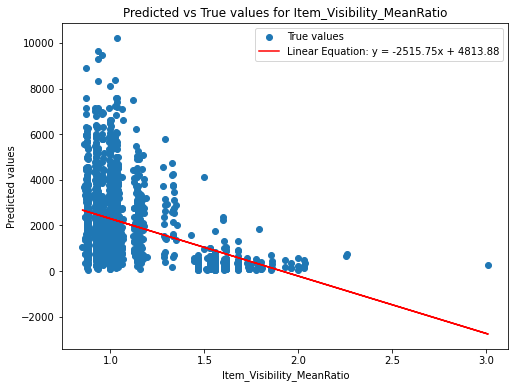

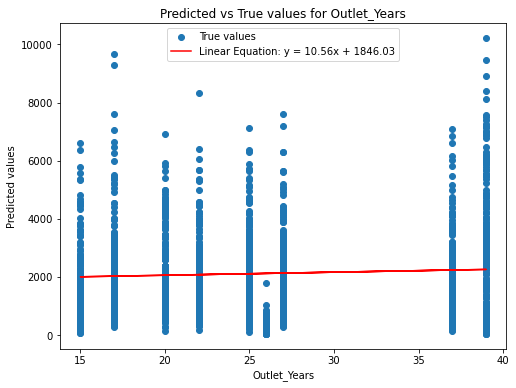

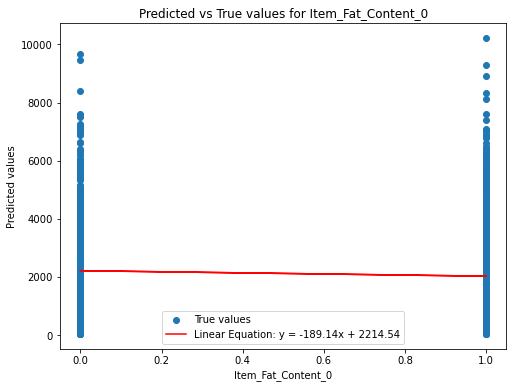

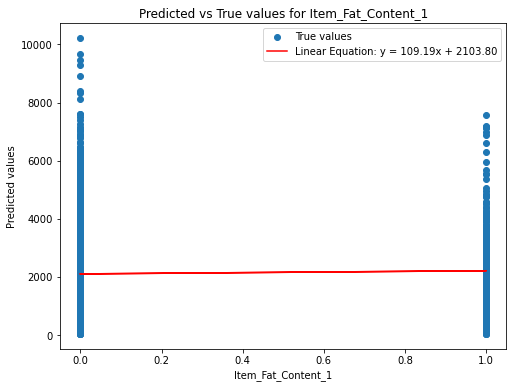

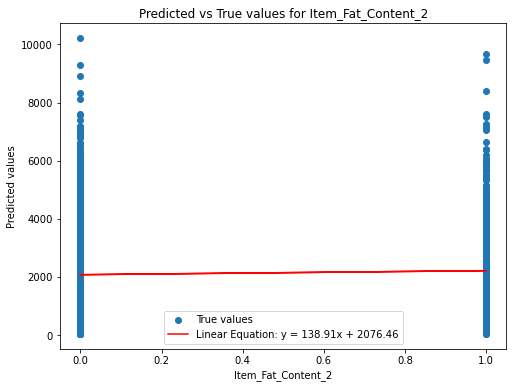

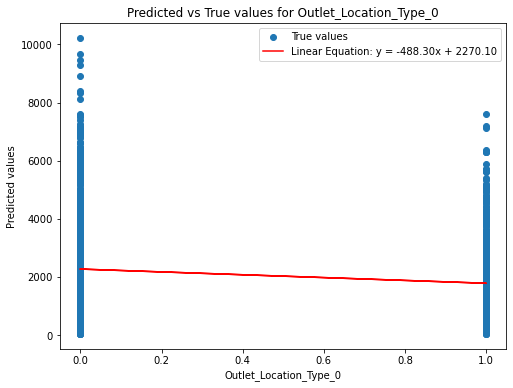

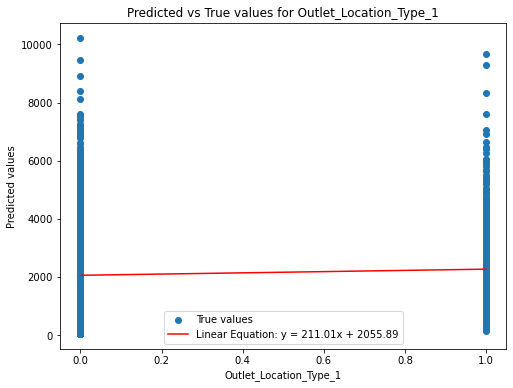

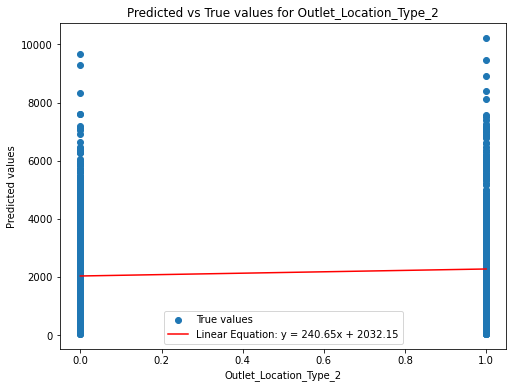

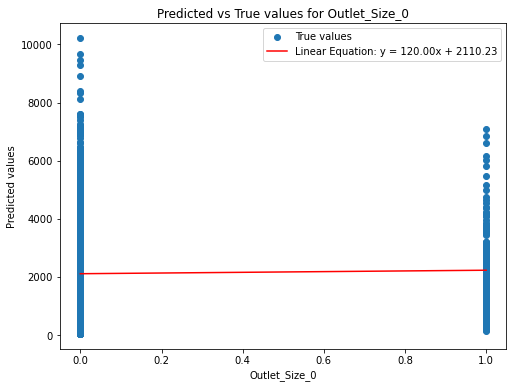

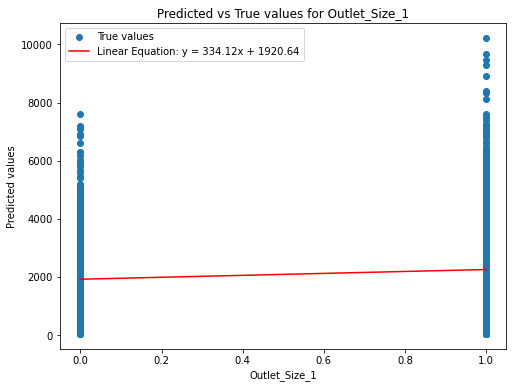

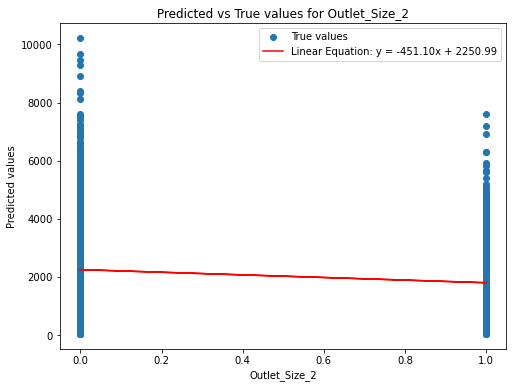

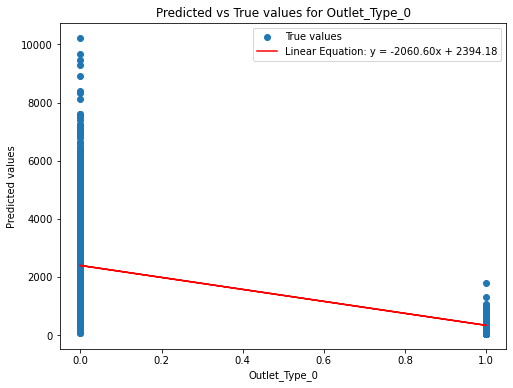

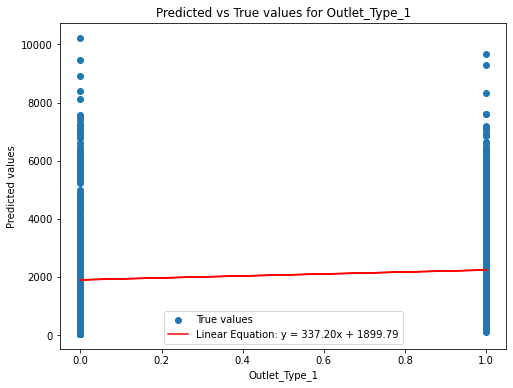

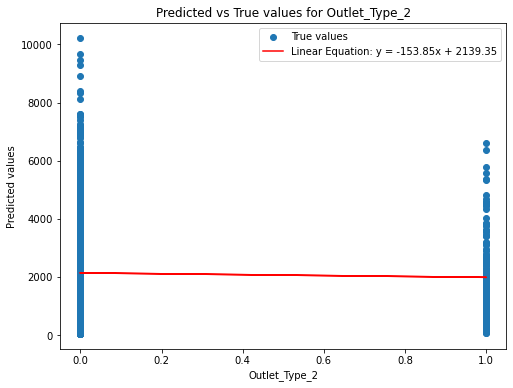

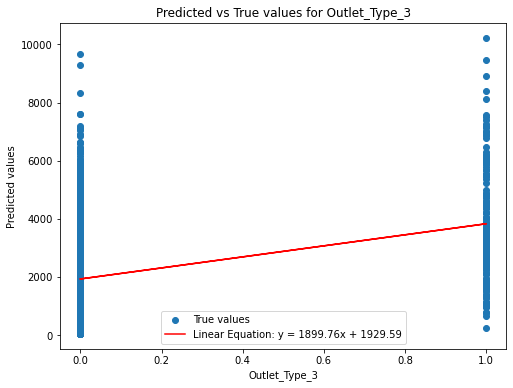

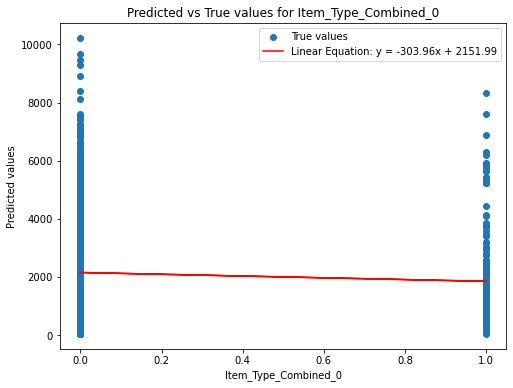

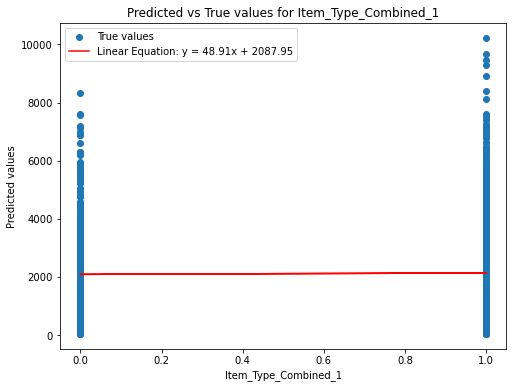

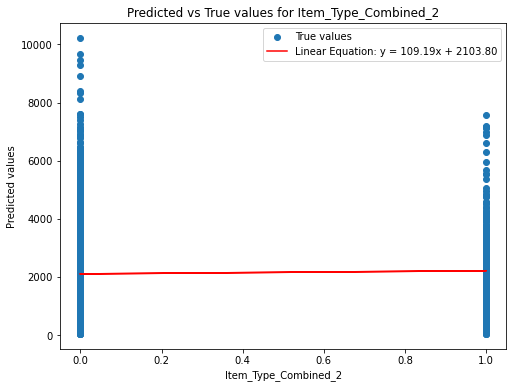

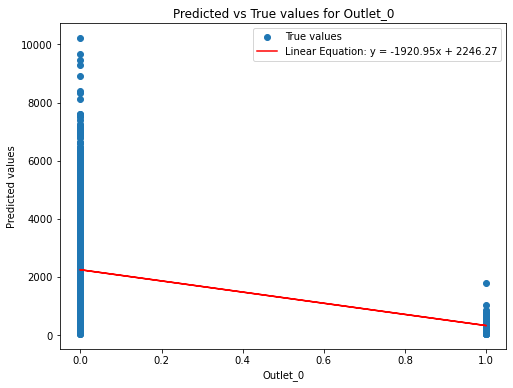

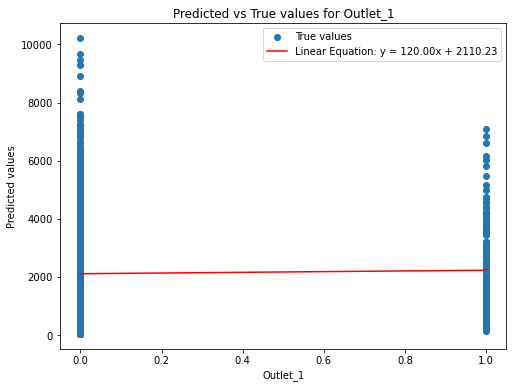

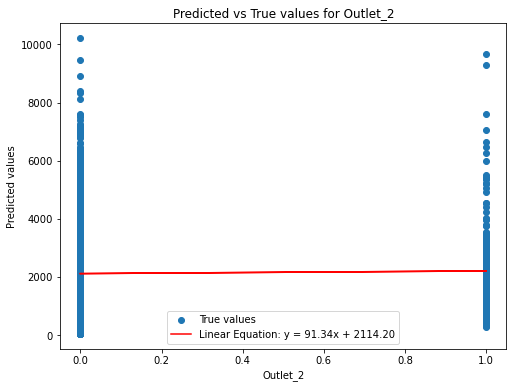

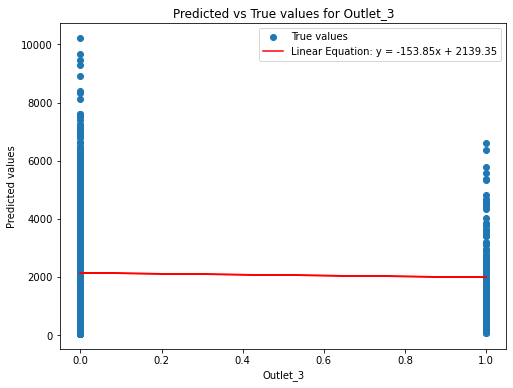

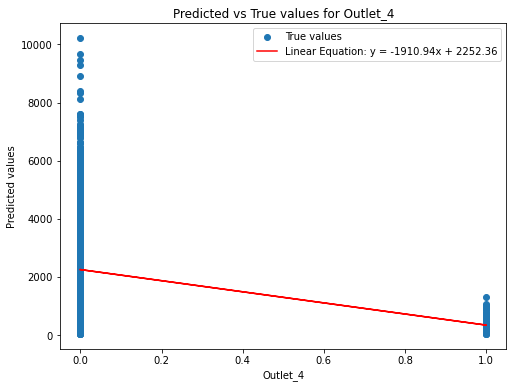

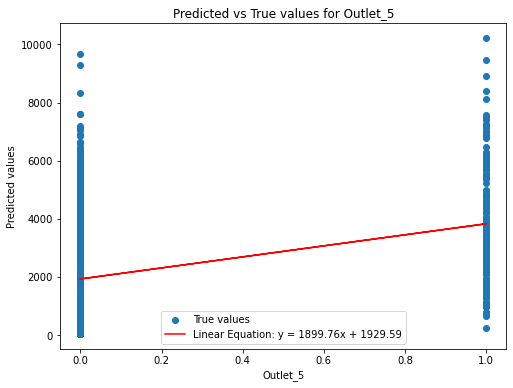

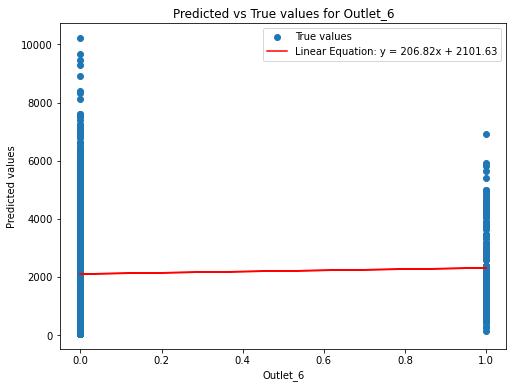

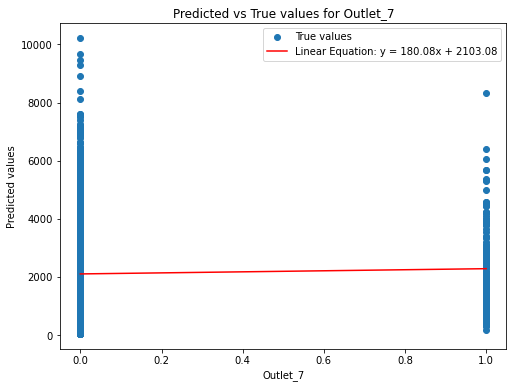

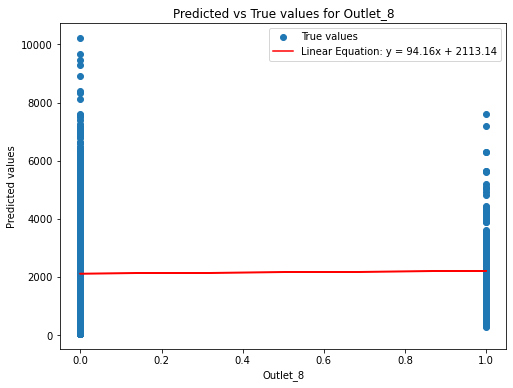

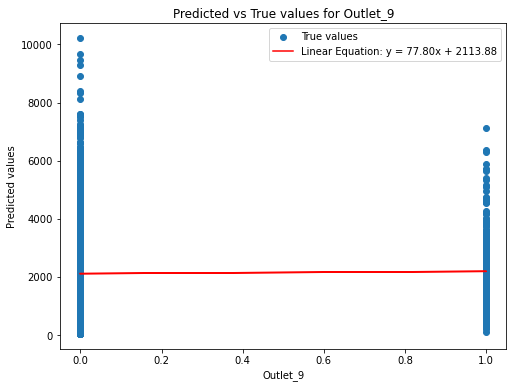

In [43]:
reg_line(pred=pred3, text=X_test)

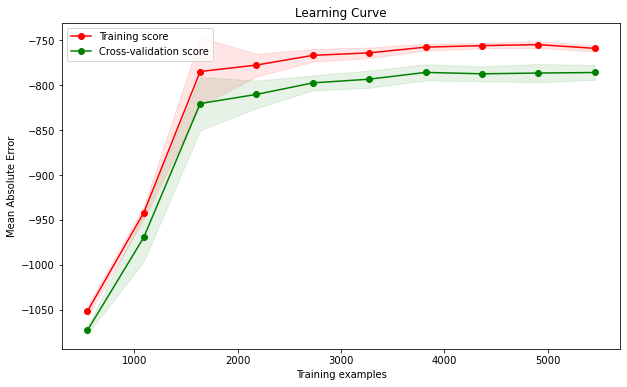

In [44]:
plot_learning_curve(model3, X_train, y_train)

XGBoost model Mean Absolute Error: 765.8309195680758


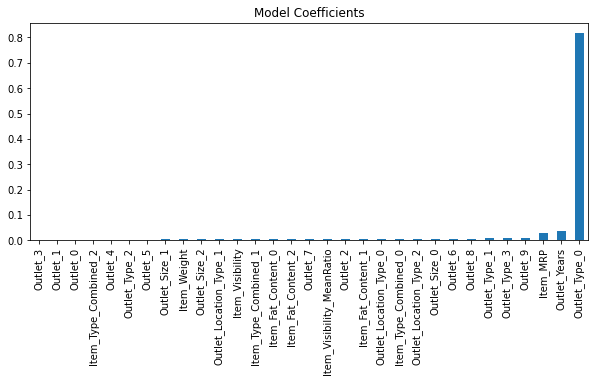

In [45]:
# instanciating XGBoost regressor
model4 = xgb.XGBRegressor()
#training model
model4.fit(X_train, y_train)
# predicting model
pred4 = model4.predict(X_test)
mae4 = mean_absolute_error(y_test,pred4)
print("XGBoost model Mean Absolute Error:", mae4)
coef4 = pd.Series(model4.feature_importances_, X_test.columns).sort_values()
plt.figure(figsize=(10, 4))
coef4.plot(kind='bar', title='Model Coefficients');

RMSE  for XGBRegressor regression:  1178.8137241483573


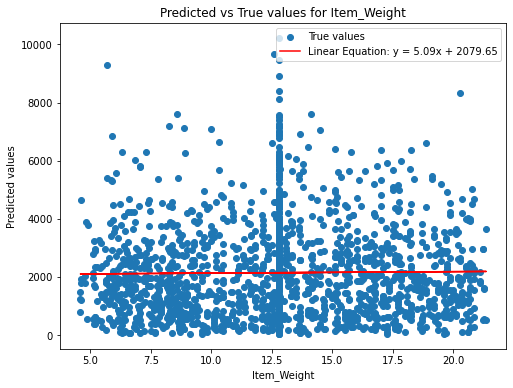

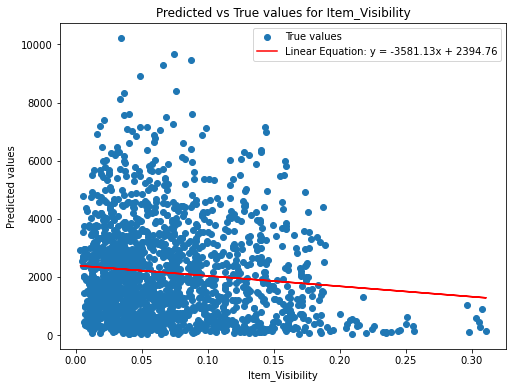

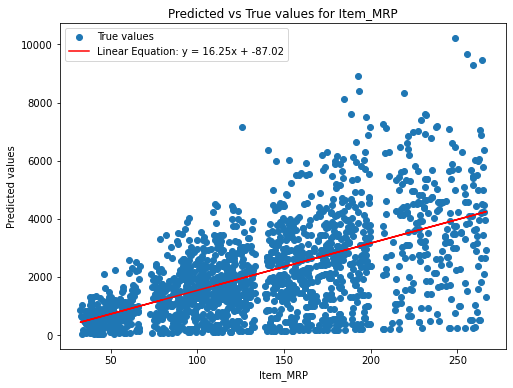

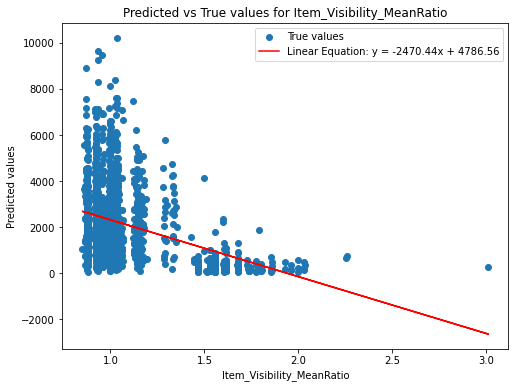

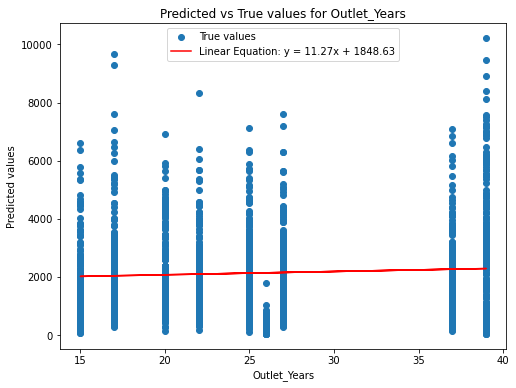

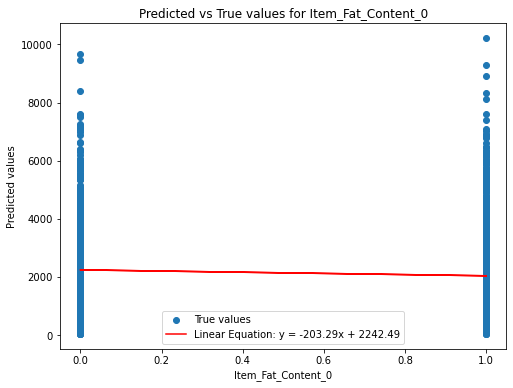

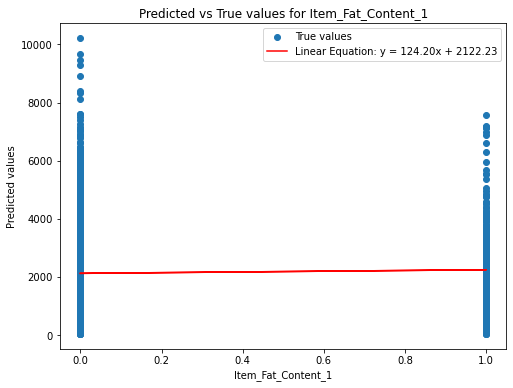

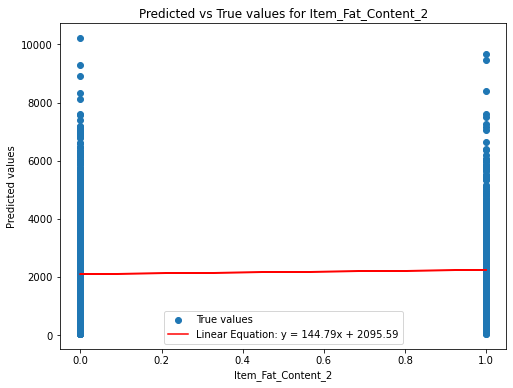

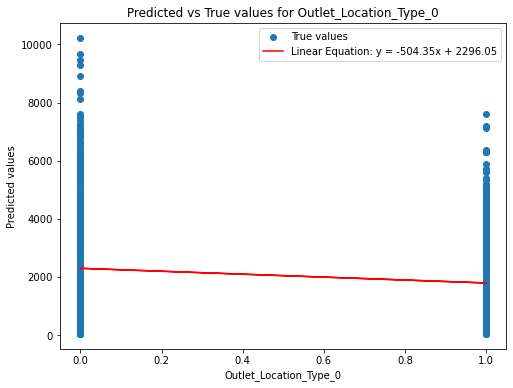

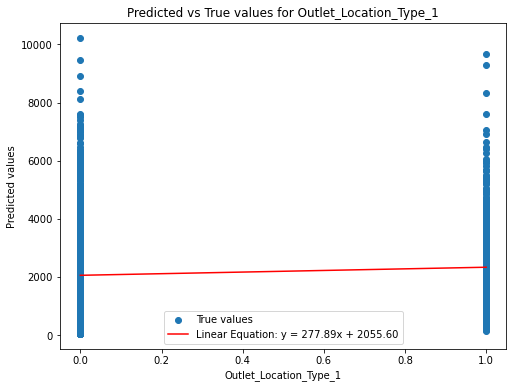

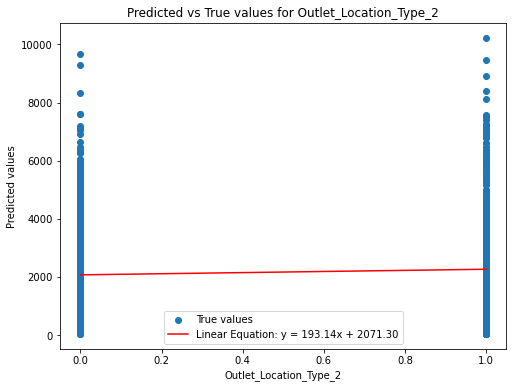

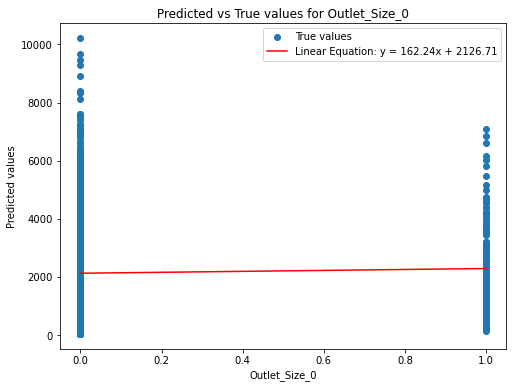

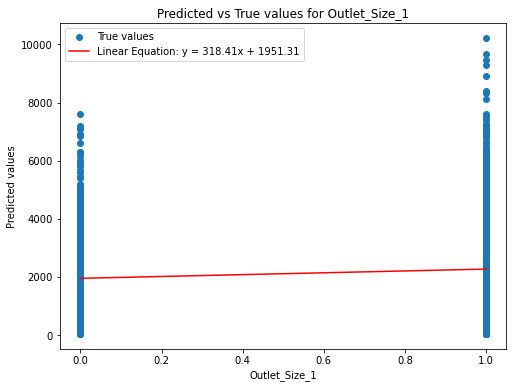

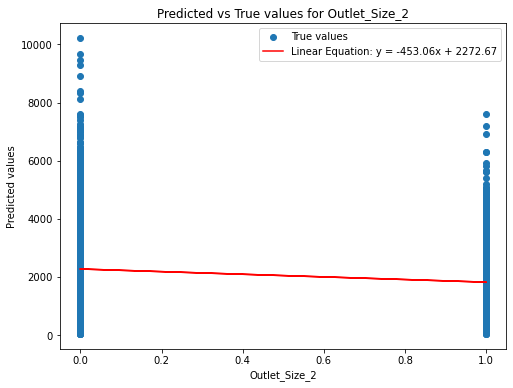

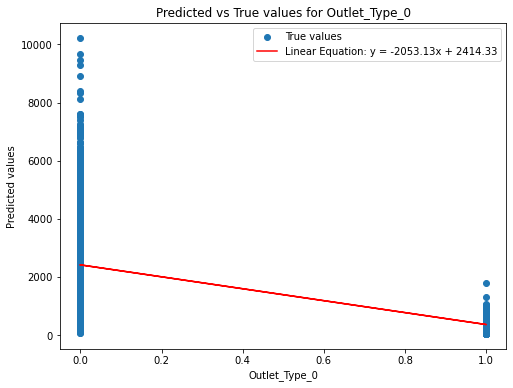

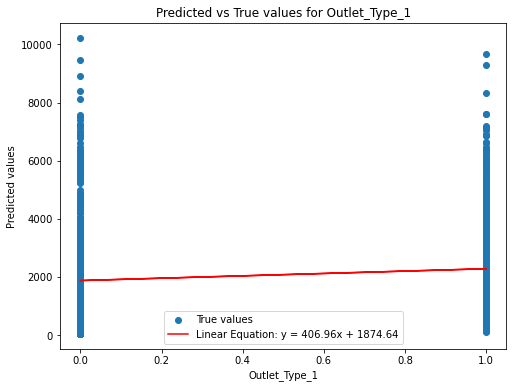

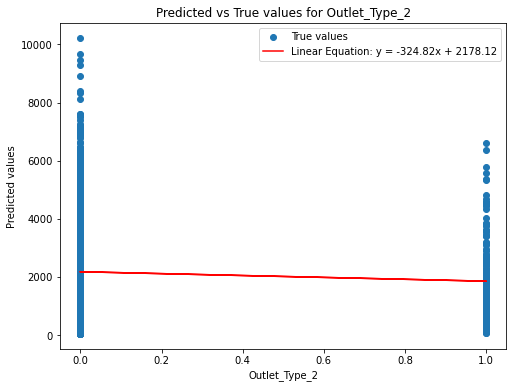

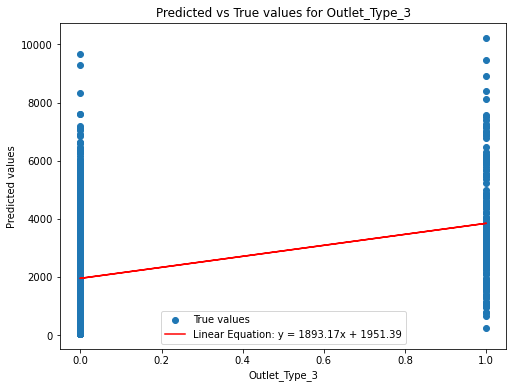

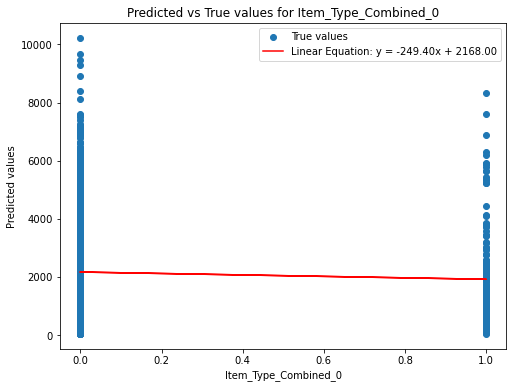

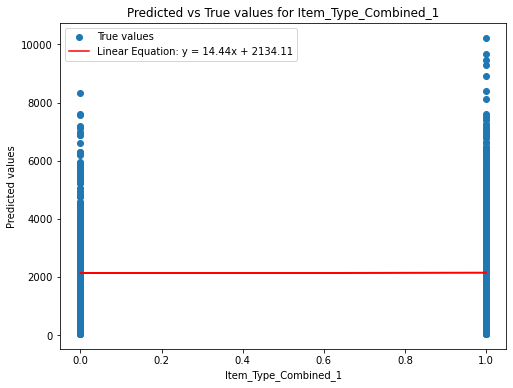

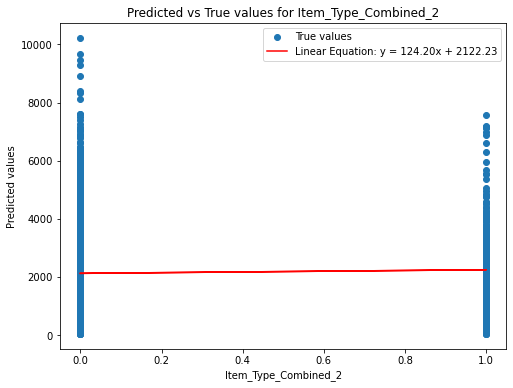

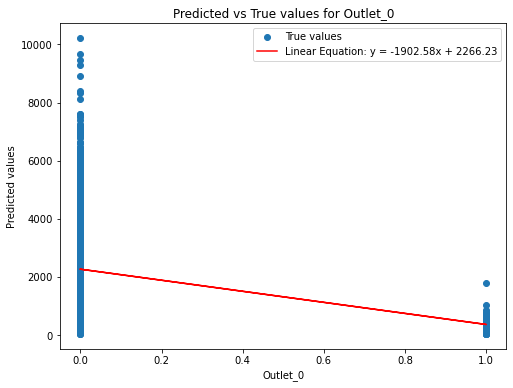

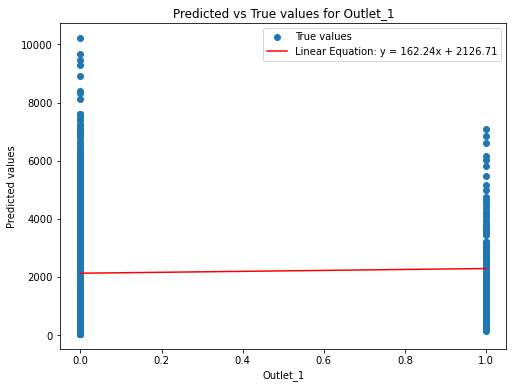

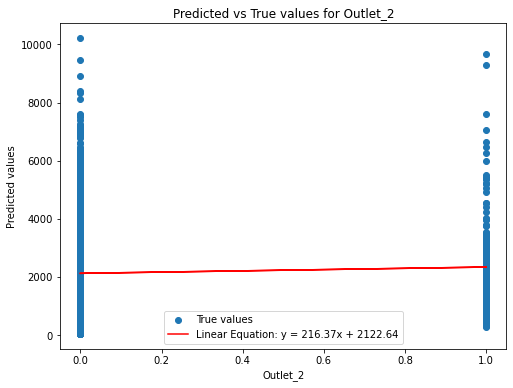

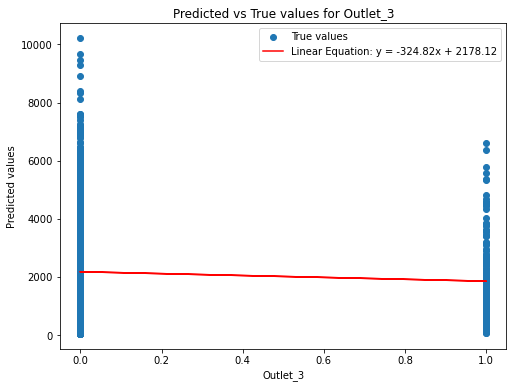

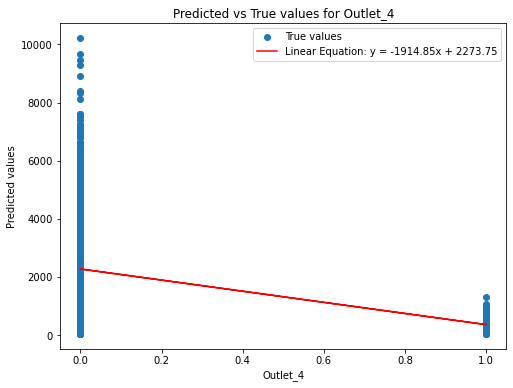

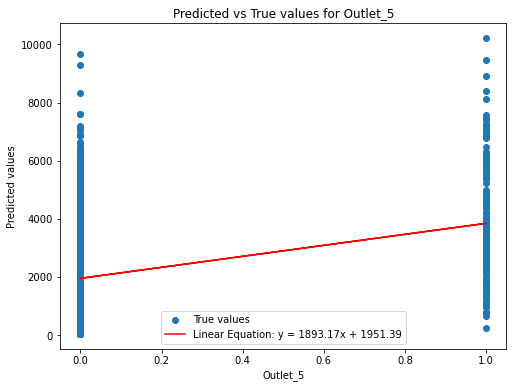

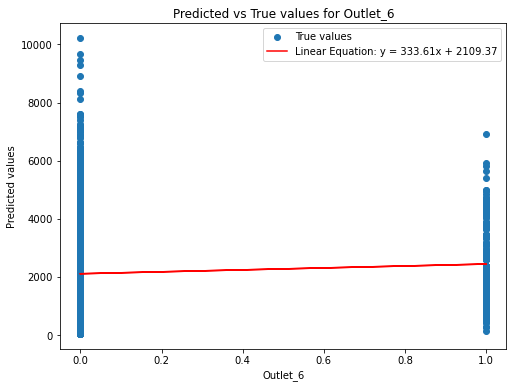

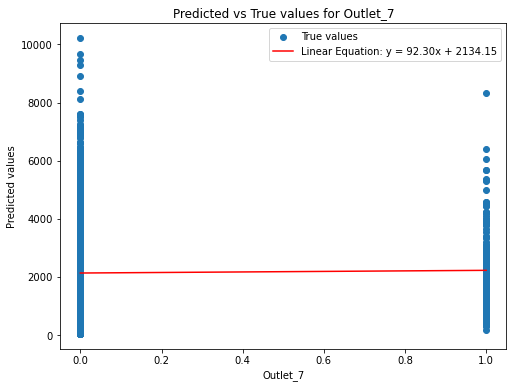

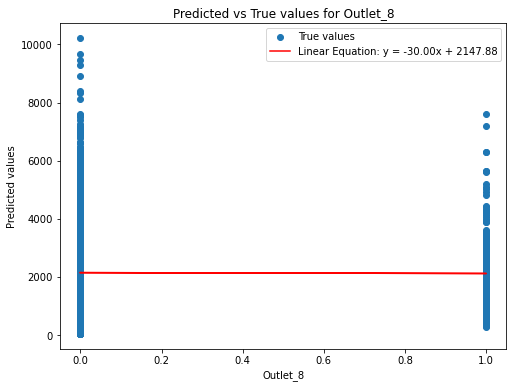

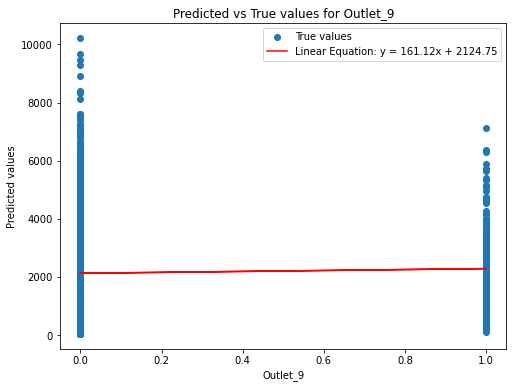

In [46]:
cv_scores4 = cross_val_score(model4, X_train, y_train, cv=20, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive and take square root to get RMSE
cv_rmse4 = np.sqrt(-cv_scores4.mean())
print('RMSE  for XGBRegressor regression: ', cv_rmse4)
reg_line(pred=pred4, text=X_test)

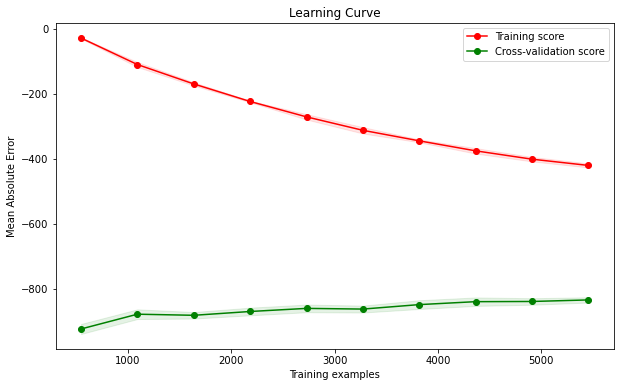

In [47]:
plot_learning_curve(model4, X_train, y_train)

In [48]:
models = ['Baseline model', 'LinearRegression', 'RidgeRegression', 'DecisionTree', 'XGBosstRegression']
mae_ = [mae, mae1, mae2, mae3, mae4]

df = pd.DataFrame({
    'Model': models,
    'Mean Absolute Error':mae_
})

# Display the dataframe
df.head()

Model  Mean Absolute Error
0     Baseline model          1357.462667
1   LinearRegression           790.996902
2    RidgeRegression           790.996902
3       DecisionTree           726.548665
4  XGBosstRegression           765.830920